In [2]:
# =============================================================================
# INITIAL SETUP AND DEPENDENCIES
# =============================================================================

!pip install google-cloud-bigquery pandas matplotlib seaborn numpy scipy
!pip install google-cloud-aiplatform
!pip install --upgrade google-cloud-bigquery-storage

from google.cloud import bigquery
from google.cloud import aiplatform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [125]:
# =============================================================================
# CLOUD CLIENT INITIALIZATION
# =============================================================================

# Initialize BigQuery client with specific GCP project
client = bigquery.Client(project='pakira2025')
aiplatform.init(project='pakira2025', location='us-central1')

In [5]:
# =============================================================================
# VISUALIZATION AND DISPLAY CONFIGURATION
# =============================================================================

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_colwidth', None)

In [6]:
# =============================================================================
# AUTHENTICATION AND DATABASE SETUP
# =============================================================================

from google.colab import auth
auth.authenticate_user()

In [76]:
# Define dataset name for storing all project tables and models
dataset_id = 'kaggle_google_trends_analysis_2025'
try:
    client.create_dataset(dataset_id)
    print(f"Created dataset {dataset_id}")
except Exception as e:
    print(f"Dataset {dataset_id} already exists or error: {e}")

Created dataset kaggle_google_trends_analysis_2025


In [77]:
# =============================================================================
# DATA PREPROCESSING AND FEATURE ENGINEERING
# =============================================================================

preprocess_query = """
CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.preprocessed_terms` AS
WITH term_stats AS (
  -- Calculate statistical aggregates for each search term
  SELECT
    term,  # Search term identifier
    COUNT(*) as frequency,
    AVG(score) as avg_score,
    MAX(score) as max_score,
    STDDEV(score) as score_stddev
  FROM `bigquery-public-data.google_trends.top_terms`
  GROUP BY term
  HAVING COUNT(*) > 52 AND AVG(score) > 10
)

-- Main SELECT with enhanced features and business logic
SELECT
  t.dma_name,
  t.term,
  t.week,
  t.rank,
  t.score,
  TIMESTAMP(t.week) as timestamp,
  s.avg_score,
  s.score_stddev,
  -- Create categorical interest levels for business interpretation
  CASE
    WHEN t.score > 80 THEN 'VERY_HIGH'
    WHEN t.score > 60 THEN 'HIGH'
    WHEN t.score > 40 THEN 'MEDIUM'
    WHEN t.score > 20 THEN 'LOW'
    ELSE 'VERY_LOW'
  END as interest_level,
  -- Statistical outlier detection using Z-score principle
  CASE
    WHEN ABS(t.score - s.avg_score) > 2 * s.score_stddev THEN TRUE   # >2σ from mean = outlier
    ELSE FALSE
  END as is_statistical_outlier  # Flag for anomaly detection
FROM `bigquery-public-data.google_trends.top_terms` t
JOIN term_stats s ON t.term = s.term
WHERE t.week >= '2023-01-01'
""".format(project_id=client.project, dataset_id=dataset_id)

# Execute the data preprocessing pipeline
try:
    client.query(preprocess_query).result()
    print("Preprocessed table created successfully")
except Exception as e:
    print(f"Error creating preprocessed table: {e}")

Preprocessed table created successfully


In [78]:
# =============================================================================
# PERFORMANCE OPTIMIZATION FOR LARGE-SCALE ANALYSIS
# =============================================================================

optimize_table_query = """
CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.preprocessed_terms_optimized`
PARTITION BY DATE(timestamp)
CLUSTER BY term, dma_name
AS
SELECT * FROM `{project_id}.{dataset_id}.preprocessed_terms`
""".format(project_id=client.project, dataset_id=dataset_id)

client.query(optimize_table_query).result()
print("Optimized table created")

Optimized table created


In [79]:
# =============================================================================
# EXPLORATORY DATA ANALYSIS - TOP TERMS IDENTIFICATION
# =============================================================================

top_terms_query = """
SELECT
  term,
  AVG(score) as avg_popularity,
  COUNT(*) as weeks_in_data,
  MAX(score) as max_popularity,
  dma_name
FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
GROUP BY term, dma_name
ORDER BY avg_popularity DESC
LIMIT 50  # Top 50 terms for analysis
""".format(project_id=client.project, dataset_id=dataset_id)


Top 50 terms by average popularity:
                       term  avg_popularity  weeks_in_data  max_popularity  \
0  wehen wiesbaden - bayern           100.0            139             100   
1          veronica echegui           100.0            139             100   
2        wolves vs west ham           100.0            139             100   
3  wehen wiesbaden - bayern           100.0            139             100   
4            world cup 2026           100.0            138             100   
5        wolves vs west ham           100.0            139             100   
6    youtube tv fox dispute           100.0            139             100   
7          veronica echegui           100.0            139             100   
8   valencia c. f. - getafe           100.0            139             100   
9          veronica echegui           100.0            139             100   

                       dma_name  
0                   New York NY  
1                   Columbus OH  
2  

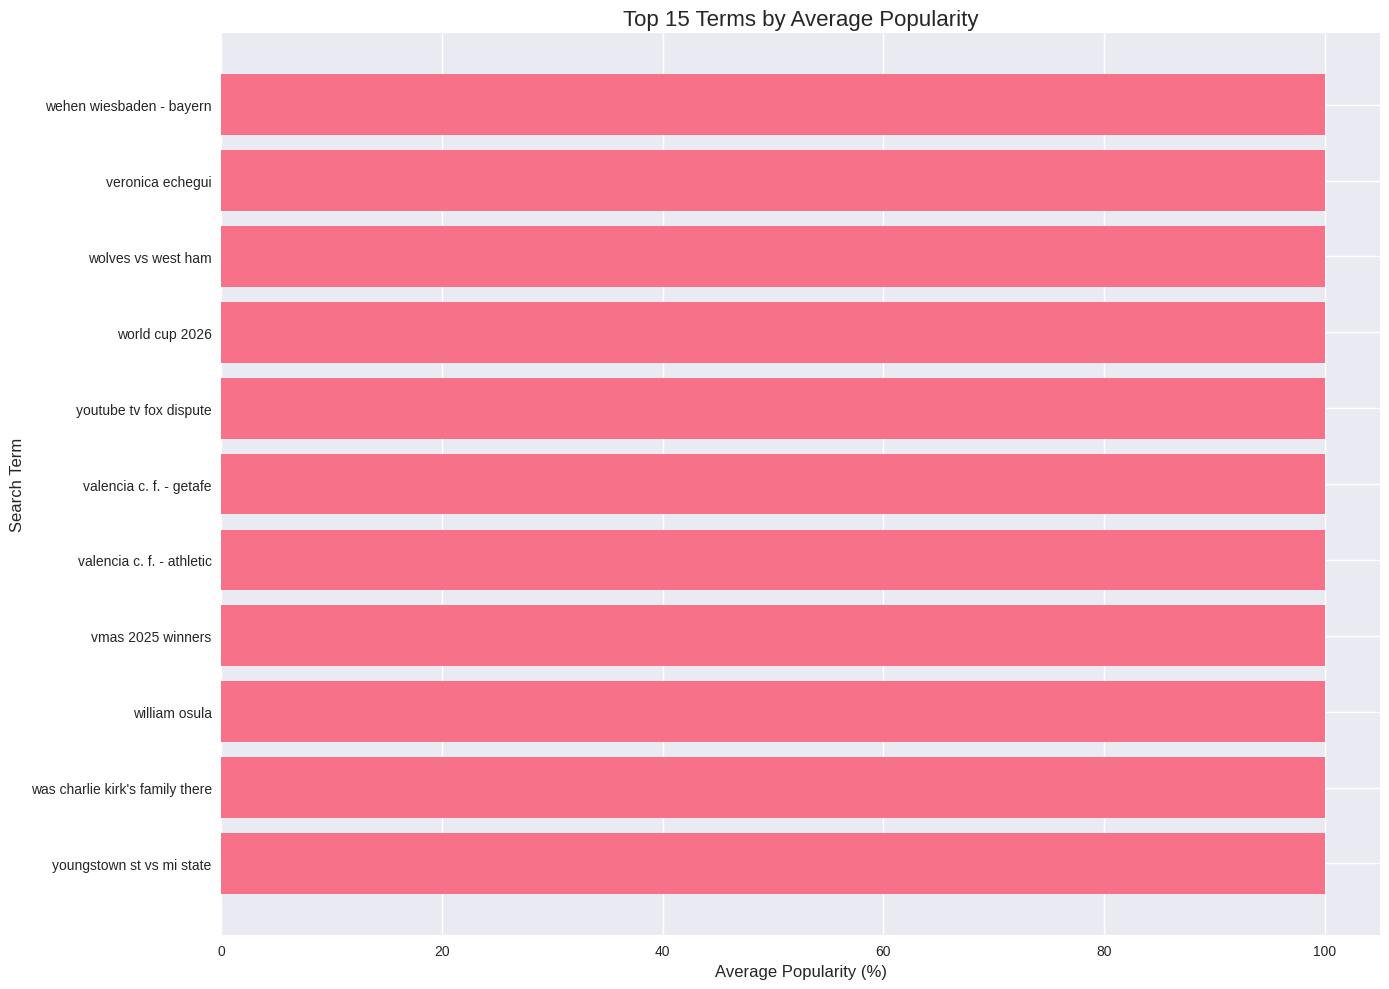

In [80]:
# Execute query and convert results to pandas DataFrame
top_terms = client.query(top_terms_query).to_dataframe()
print("Top 50 terms by average popularity:")
print(top_terms.head(10))

plt.figure(figsize=(14, 10))
plt.barh(top_terms['term'].head(15), top_terms['avg_popularity'].head(15))
plt.title('Top 15 Terms by Average Popularity', fontsize=16)
plt.xlabel('Average Popularity (%)', fontsize=12)
plt.ylabel('Search Term', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_terms.png', dpi=300, bbox_inches='tight')
plt.show()

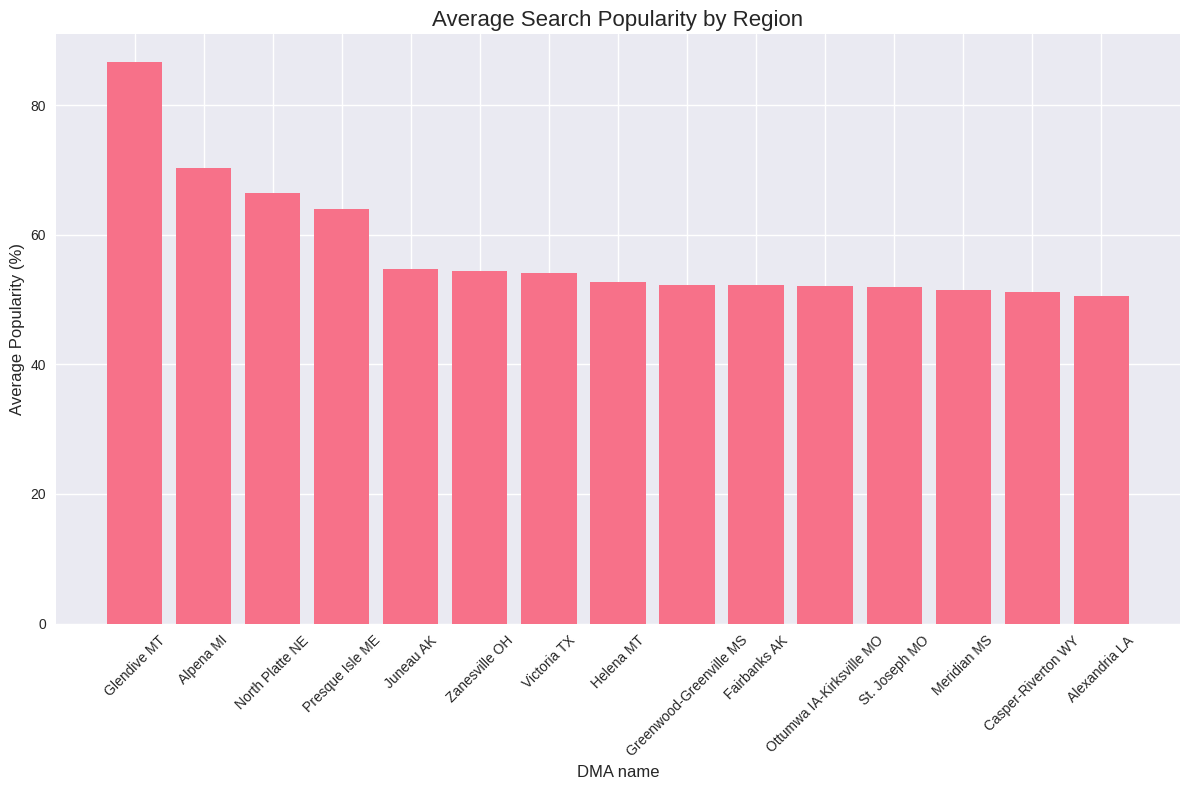

In [81]:
# =============================================================================
# REGIONAL ANALYSIS - GEOGRAPHIC PATTERN IDENTIFICATION
# =============================================================================

regional_query = """
SELECT
  dma_name,
  COUNT(DISTINCT term) as unique_terms,
  AVG(score) as avg_popularity
FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
GROUP BY dma_name
HAVING unique_terms > 50
ORDER BY avg_popularity DESC
LIMIT 15
""".format(project_id=client.project, dataset_id=dataset_id)

regional_data = client.query(regional_query).to_dataframe()

plt.figure(figsize=(12, 8))
plt.bar(regional_data['dma_name'], regional_data['avg_popularity'])
plt.title('Average Search Popularity by Region', fontsize=16)
plt.xlabel('DMA name', fontsize=12)
plt.ylabel('Average Popularity (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('regional_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [83]:
# =============================================================================
# DATA QUALITY CHECK - TERM AVAILABILITY VALIDATION
# =============================================================================

check_terms_query = """
SELECT DISTINCT term
FROM `{project_id}.{dataset_id}.preprocessed_terms`
ORDER BY term
LIMIT 20
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    available_terms = client.query(check_terms_query).to_dataframe()
    print("Available terms in preprocessed data:")
    print(available_terms)
except Exception as e:
    print(f"Error checking available terms: {e}")


Available terms in preprocessed data:
                                term
0   11 year old shot ding dong ditch
1             30 year mortgage rates
2                    49ers vs saints
3                       911 memorial
4                      abrego garcia
5                    aces vs mystics
6                         adbe stock
7                    adley rutschman
8                                adn
9                      adrien broner
10           afghanistan vs pakistan
11                    after the hunt
12                          airlines
13                      airpod pro 3
14                     ajax vs inter
15              al taawon - al-nassr
16            al-nassr vs al kholood
17             al-nassr vs al-riyadh
18              al-nassr vs istiklol
19            al-taawoun vs al-nassr


In [126]:
# =============================================================================
# SPECIFIC TERM VALIDATION FOR TARGETED ANALYSIS
# =============================================================================

check_specific_terms_query = """
SELECT term, COUNT(*) as count
FROM `{project_id}.{dataset_id}.preprocessed_terms`
WHERE term IN ('artificial intelligence', 'machine learning', 'data science')
GROUP BY term
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    specific_terms = client.query(check_specific_terms_query).to_dataframe()
    print("Specific terms availability:")
    print(specific_terms)

    # Fallback logic if target terms are not available
    if specific_terms.empty:
        print("None of the specified terms were found. Let's use available terms instead.")
        actual_terms_query = """
        SELECT term, COUNT(*) as count
        FROM `{project_id}.{dataset_id}.preprocessed_terms`
        GROUP BY term
        ORDER BY count DESC
        LIMIT 3
        """.format(project_id=client.project, dataset_id=dataset_id)
        actual_terms = client.query(actual_terms_query).to_dataframe()
        print("Top 3 available terms:")
        print(actual_terms)
        model_terms = actual_terms['term'].tolist()
    else:
        model_terms = specific_terms['term'].tolist()

except Exception as e:
    print(f"Error checking specific terms: {e}")
    model_terms = []

# Final fallback if no terms identified
if not model_terms:
    print("Falling back to a single term approach")
    fallback_term_query = """
    SELECT term
    FROM `{project_id}.{dataset_id}.preprocessed_terms`
    GROUP BY term
    ORDER BY COUNT(*) DESC
    LIMIT 1
    """.format(project_id=client.project, dataset_id=dataset_id)
    fallback_term = client.query(fallback_term_query).to_dataframe()
    model_terms = fallback_term['term'].tolist()

print(f"Using terms for modeling: {model_terms}")

Specific terms availability:
Empty DataFrame
Columns: [term, count]
Index: []
None of the specified terms were found. Let's use available terms instead.
Top 3 available terms:
           term  count
0    nfl scores  59850
1  carson wentz  59850
2  robo shankar  59640
Using terms for modeling: ['nfl scores', 'carson wentz', 'robo shankar']


In [85]:
# =============================================================================
# INITIAL FORECASTING MODEL IMPLEMENTATION
# =============================================================================

simple_forecast_query = """
CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.simple_forecast_model`
OPTIONS(
  model_type = 'ARIMA_PLUS',
  time_series_timestamp_col = 'timestamp',
  time_series_data_col = 'score',
  time_series_id_col = 'term',
  horizon = 12,
  auto_arima = TRUE,
  data_frequency = 'WEEKLY'
) AS
SELECT
  timestamp,
  score,
  term
FROM `{project_id}.{dataset_id}.preprocessed_terms`
WHERE term IN UNNEST({terms})
""".format(
    project_id=client.project,
    dataset_id=dataset_id,
    terms=model_terms
)

try:
    client.query(simple_forecast_query).result()
    print("Simple forecast model created successfully")

    # Model evaluation query to assess performance
    evaluate_query = """
    SELECT *
    FROM ML.EVALUATE(MODEL `{project_id}.{dataset_id}.simple_forecast_model`)
    """.format(project_id=client.project, dataset_id=dataset_id)

    evaluation = client.query(evaluate_query).to_dataframe()
    print("Model evaluation:")
    print(evaluation)

except Exception as e:
    print(f"Error creating simple forecast model: {e}")
    print("Let's try an even simpler approach with just one term")

    # Fallback: Single-term model with simplified configuration
    single_term_query = """
    CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.single_term_model`
    OPTIONS(
      model_type = 'ARIMA_PLUS',
      time_series_timestamp_col = 'timestamp',
      time_series_data_col = 'score',
      horizon = 12,
      auto_arima = TRUE,
      data_frequency = 'WEEKLY'
    ) AS
    SELECT
      timestamp,
      score
    FROM `{project_id}.{dataset_id}.preprocessed_terms`
    WHERE term = '{term}'
    ORDER BY timestamp
    """.format(
        project_id=client.project,
        dataset_id=dataset_id,
        term=model_terms[0] if model_terms else list(available_terms['term'])[0]
    )

    try:
        client.query(single_term_query).result()
        print("Single term model created successfully")
    except Exception as e:
        print(f"Error creating single term model: {e}")
        print("This suggests there might be an issue with the preprocessed data")

        # Data quality check: Count rows in preprocessed data
        check_data_query = """
        SELECT COUNT(*) as row_count  # Total row count
        FROM `{project_id}.{dataset_id}.preprocessed_terms`
        """.format(project_id=client.project, dataset_id=dataset_id)

        data_count = client.query(check_data_query).to_dataframe()
        print(f"Rows in preprocessed data: {data_count['row_count'].values[0]}")

Simple forecast model created successfully
Model evaluation:
              term  non_seasonal_p  non_seasonal_d  non_seasonal_q  has_drift  \
0     carson wentz               1               0               0      False   
1  clayton kershaw               0               0               2      False   
2       nfl scores               0               1               2      False   

   log_likelihood          AIC    variance  seasonal_periods  \
0     -532.061410  1070.122820   99.805802  [NO_SEASONALITY]   
1     -550.026475  1108.052951  135.378124  [NO_SEASONALITY]   
2     -440.548071   887.096141   28.898195          [YEARLY]   

   has_holiday_effect  has_spikes_and_dips  has_step_changes  
0               False                 True             False  
1               False                 True             False  
2               False                 True             False  


In [127]:
# =============================================================================
# ADVANCED MODELING WITH HYPERPARAMETER TUNING
# =============================================================================

available_terms_query = """
SELECT
  term,
  COUNT(*) as data_points,
  AVG(score) as avg_score,
  MIN(week) as first_week,
  MAX(week) as last_week
FROM `{project_id}.{dataset_id}.preprocessed_terms`
GROUP BY term
HAVING data_points > 52
ORDER BY avg_score DESC
LIMIT 10
""".format(project_id=client.project, dataset_id=dataset_id)

available_terms = client.query(available_terms_query).to_dataframe()
print("Available terms with sufficient data for forecasting:")
print(available_terms)

model_terms = available_terms['term'].head(3).tolist()
print(f"Selected terms for modeling: {model_terms}")

model_configs = {
    'model_baseline': {
        'horizon': 12,
        'auto_arima': 'TRUE',
        'data_frequency': "'WEEKLY'",
        'decompose_time_series': 'TRUE'
    },
    'model_tuned_1': {
        'horizon': 12,
        'auto_arima': 'TRUE',
        'data_frequency': "'WEEKLY'",
        'decompose_time_series': 'TRUE',
        'auto_arima_max_order': 5
    },
    'model_tuned_2': {
        'horizon': 8,
        'auto_arima': 'TRUE',
        'data_frequency': "'WEEKLY'",
        'decompose_time_series': 'TRUE',
        'auto_arima_min_order': 1
    },
    'model_tuned_3': {
        'horizon': 16,
        'auto_arima': 'TRUE',
        'data_frequency': "'WEEKLY'",
        'decompose_time_series': 'FALSE'
    }
}

Available terms with sufficient data for forecasting:
                            term  data_points  avg_score  first_week  \
0  power ball numbers for aug 30        29190  90.724138  2023-01-01   
1                  bernie parent        30030  90.076023  2023-01-01   
2           croacia - montenegro        29610  88.444444  2023-01-01   
3                tamar shirinian        29820  88.113402  2023-01-01   
4                inter - udinese        29400  87.976608  2023-01-01   
5              sevilla vs getafe        29190  87.500000  2023-01-01   
6             rampage jackson jr        29190  86.676136  2023-01-01   
7  super mario bros galaxy movie        29820  86.671233  2023-01-01   
8     crystal palace vs millwall        29820  86.500000  2023-01-01   
9                  como vs genoa        29820  86.203008  2023-01-01   

    last_week  
0  2025-08-24  
1  2025-09-21  
2  2025-09-07  
3  2025-09-14  
4  2025-08-31  
5  2025-08-24  
6  2025-08-24  
7  2025-09-14  
8  2025-0

In [128]:
# Function to create forecasting models with specific hyperparameters
def create_forecast_model(model_name, hyperparams):
    options_parts = [
        "model_type = 'ARIMA_PLUS'",
        "time_series_timestamp_col = 'timestamp'",
        "time_series_data_col = 'score'",
        "time_series_id_col = 'term'",
        f"horizon = {hyperparams['horizon']}",
        f"auto_arima = {hyperparams['auto_arima']}",
        f"data_frequency = {hyperparams['data_frequency']}",
        f"decompose_time_series = {hyperparams['decompose_time_series']}"
    ]

    if 'auto_arima_max_order' in hyperparams:
        options_parts.append(f"auto_arima_max_order = {hyperparams['auto_arima_max_order']}")
    if 'auto_arima_min_order' in hyperparams:
        options_parts.append(f"auto_arima_min_order = {hyperparams['auto_arima_min_order']}")

    options_str = ",\n      ".join(options_parts)

    query = """
    CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.{model_name}`
    OPTIONS(
      {options_str}
    ) AS
    SELECT
      timestamp,
      score,
      term
    FROM `{project_id}.{dataset_id}.preprocessed_terms`
    WHERE term IN UNNEST({terms})
    """.format(
        project_id=client.project,
        dataset_id=dataset_id,
        model_name=model_name,
        options_str=options_str,
        terms=model_terms
    )

    try:
        client.query(query).result()
        print(f"Model {model_name} created successfully")
        return True
    except Exception as e:
        print(f"Error creating model {model_name}: {e}")
        return False

successful_models = []
for model_name, config in model_configs.items():
    if create_forecast_model(model_name, config):
        successful_models.append(model_name)

print(f"Successfully created {len(successful_models)} models: {successful_models}")

Model model_baseline created successfully
Model model_tuned_1 created successfully
Model model_tuned_2 created successfully
Model model_tuned_3 created successfully
Successfully created 4 models: ['model_baseline', 'model_tuned_1', 'model_tuned_2', 'model_tuned_3']


Evaluation for model_baseline completed
Evaluation for model_tuned_1 completed
Evaluation for model_tuned_2 completed
Evaluation for model_tuned_3 completed
Model evaluation results (ARIMA parameters):
       model_name                           term  non_seasonal_p  \
0  model_baseline                  bernie parent               2   
1  model_baseline           croacia - montenegro               1   
2  model_baseline  power ball numbers for aug 30               1   
0   model_tuned_1                  bernie parent               2   
1   model_tuned_1           croacia - montenegro               1   
2   model_tuned_1  power ball numbers for aug 30               3   
0   model_tuned_2                  bernie parent               2   
1   model_tuned_2           croacia - montenegro               1   
2   model_tuned_2  power ball numbers for aug 30               1   
0   model_tuned_3                  bernie parent               2   
1   model_tuned_3           croacia - montenegro  

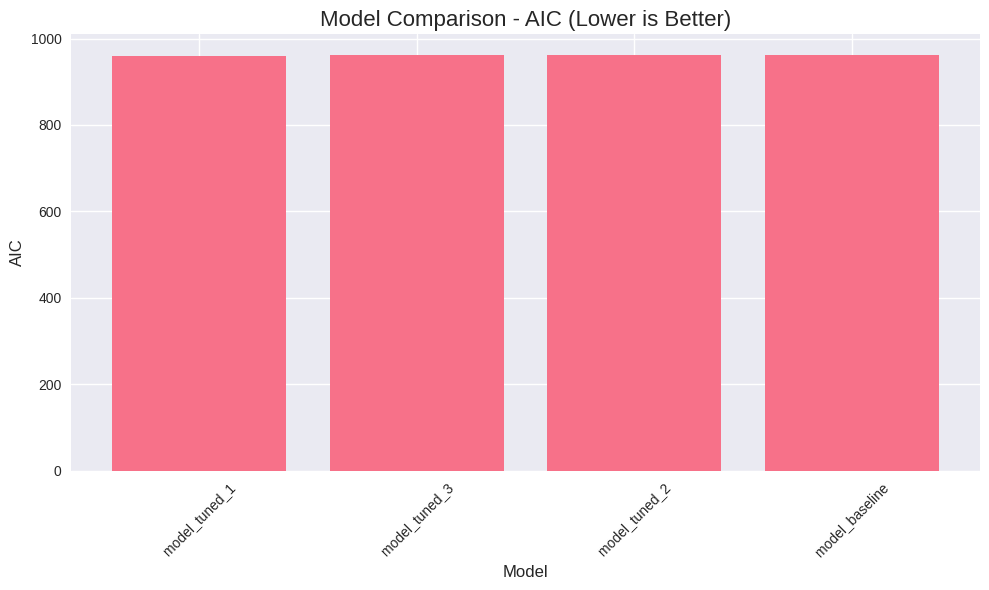

In [129]:
# =============================================================================
# MODEL EVALUATION AND COMPARISON
# =============================================================================

evaluation_results = []

for model_name in successful_models:
    try:
        evaluate_query = """
        SELECT
          '{model_name}' as model_name,
          term,
          non_seasonal_p,
          non_seasonal_d,
          non_seasonal_q,
          has_drift,
          log_likelihood,
          AIC,
          variance
        FROM ML.ARIMA_EVALUATE(MODEL `{project_id}.{dataset_id}.{model_name}`)
        """.format(project_id=client.project, dataset_id=dataset_id, model_name=model_name)

        result = client.query(evaluate_query).to_dataframe()
        evaluation_results.append(result)
        print(f"Evaluation for {model_name} completed")

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")

# Combine all evaluation results for comprehensive analysis
if evaluation_results:
    all_evaluations = pd.concat(evaluation_results)

    print("Model evaluation results (ARIMA parameters):")
    print(all_evaluations)

    if 'AIC' in all_evaluations.columns:
        aic_comparison = all_evaluations.groupby('model_name')['AIC'].mean().reset_index()
        aic_comparison = aic_comparison.sort_values('AIC')

        print("\nModel comparison based on AIC (lower is better):")
        print(aic_comparison)

        best_model_name = aic_comparison.iloc[0]['model_name']
        print(f"\nBest model based on AIC: {best_model_name}")

        plt.figure(figsize=(10, 6))
        plt.bar(aic_comparison['model_name'], aic_comparison['AIC'])
        plt.title('Model Comparison - AIC (Lower is Better)', fontsize=16)
        plt.xlabel('Model', fontsize=12)
        plt.ylabel('AIC', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('model_aic_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        best_model_name = successful_models[0] if successful_models else 'simple_forecast_model'
        print(f"\nUsing first successful model: {best_model_name}")
else:
    print("No evaluation results available. Creating a simple forecast model instead.")

    simple_model_query = """
    CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.simple_forecast_model`
    OPTIONS(
      model_type = 'ARIMA_PLUS',
      time_series_timestamp_col = 'timestamp',
      time_series_data_col = 'score',
      time_series_id_col = 'term',
      horizon = 12,
      auto_arima = TRUE,
      data_frequency = 'WEEKLY'
    ) AS
    SELECT
      timestamp,
      score,
      term
    FROM `{project_id}.{dataset_id}.preprocessed_terms`
    WHERE term IN UNNEST({terms})
    """.format(project_id=client.project, dataset_id=dataset_id, terms=model_terms)

    client.query(simple_model_query).result()
    best_model_name = 'simple_forecast_model'
    print("Simple forecast model created as fallback")

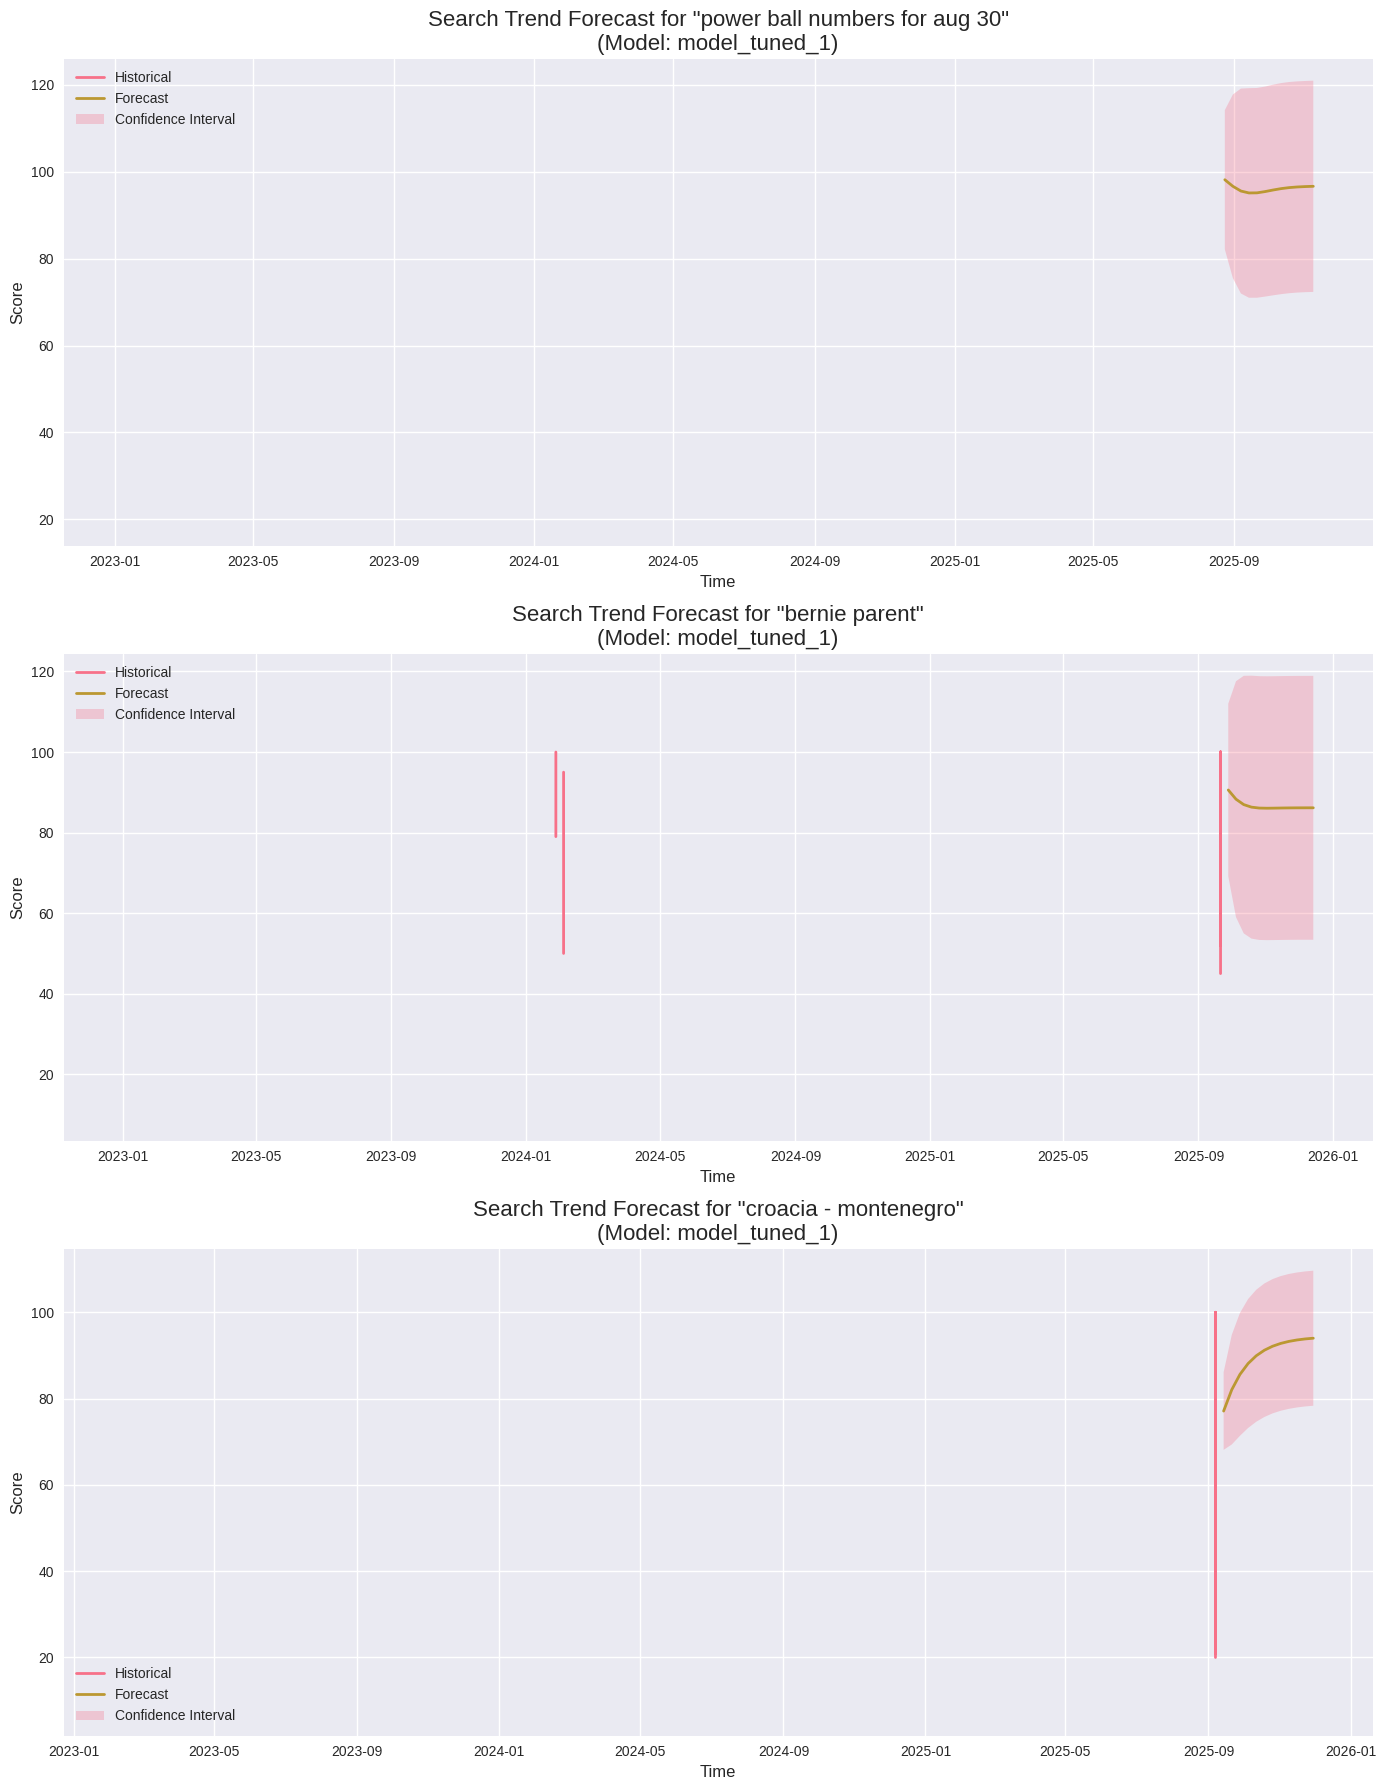


Forecast Summary:

power ball numbers for aug 30:
  Average forecast: 96.2
  Confidence interval width: 46.5
  Forecast horizon: 12 weeks

bernie parent:
  Average forecast: 86.8
  Confidence interval width: 62.9
  Forecast horizon: 12 weeks

croacia - montenegro:
  Average forecast: 89.5
  Confidence interval width: 29.2
  Forecast horizon: 12 weeks


In [95]:

# =============================================================================
# SIMPLIFIED FORECAST GENERATION AND VISUALIZATION (NO AI)
# =============================================================================

forecast_query = """
SELECT *
FROM ML.FORECAST(MODEL `{project_id}.{dataset_id}.{model_name}`,
                 STRUCT(12 AS horizon))
""".format(project_id=client.project, dataset_id=dataset_id, model_name=best_model_name)

try:
    forecast_results = client.query(forecast_query).to_dataframe()

    historical_query = """
    SELECT
      timestamp,
      score,
      term
    FROM `{project_id}.{dataset_id}.preprocessed_terms`
    WHERE term IN UNNEST({terms})
    ORDER BY timestamp
    """.format(project_id=client.project, dataset_id=dataset_id, terms=model_terms)

    historical_data = client.query(historical_query).to_dataframe()

    fig, axes = plt.subplots(len(model_terms), 1, figsize=(14, 6*len(model_terms)))
    if len(model_terms) == 1:
        axes = [axes]

    for i, term in enumerate(model_terms):
        term_historical = historical_data[historical_data['term'] == term]
        term_forecast = forecast_results[forecast_results['term'] == term]

        axes[i].plot(term_historical['timestamp'], term_historical['score'],
                     label='Historical', linewidth=2)
        axes[i].plot(term_forecast['forecast_timestamp'], term_forecast['forecast_value'],
                     label='Forecast', linewidth=2)
        axes[i].fill_between(term_forecast['forecast_timestamp'],
                             term_forecast['confidence_interval_lower_bound'],
                             term_forecast['confidence_interval_upper_bound'],
                             alpha=0.3, label='Confidence Interval')

        axes[i].set_title(f'Search Trend Forecast for "{term}"\n(Model: {best_model_name})', fontsize=16)
        axes[i].set_xlabel('Time', fontsize=12)
        axes[i].set_ylabel('Score', fontsize=12)
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig('forecast_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nForecast Summary:")
    for term in model_terms:
        term_forecast = forecast_results[forecast_results['term'] == term]
        if len(term_forecast) > 0:
            avg_forecast = term_forecast['forecast_value'].mean()
            confidence_width = (term_forecast['confidence_interval_upper_bound'] -
                              term_forecast['confidence_interval_lower_bound']).mean()

            print(f"\n{term}:")
            print(f"  Average forecast: {avg_forecast:.1f}")
            print(f"  Confidence interval width: {confidence_width:.1f}")
            print(f"  Forecast horizon: {len(term_forecast)} weeks")

except Exception as e:
    print(f"Error generating forecast: {e}")

In [130]:
# =============================================================================
# MANUAL MODEL VALIDATION AND ERROR METRICS
# =============================================================================

print("\nPerforming manual evaluation by comparing forecasts to actuals...")

for model_name in successful_models:
    try:
        recent_data_query = """
        WITH recent_data AS (
          SELECT
            term,
            MAX(timestamp) as latest_timestamp
          FROM `{project_id}.{dataset_id}.preprocessed_terms`
          GROUP BY term
        )
        SELECT
          t.term,
          t.timestamp,
          t.score as actual_score
        FROM `{project_id}.{dataset_id}.preprocessed_terms` t
        JOIN recent_data r ON t.term = r.term AND t.timestamp = r.latest_timestamp
        WHERE t.term IN UNNEST({terms})
        """.format(project_id=client.project, dataset_id=dataset_id, terms=model_terms)

        recent_data = client.query(recent_data_query).to_dataframe()

        forecast_query = """
        SELECT
          term,
          forecast_value,
          confidence_interval_lower_bound,
          confidence_interval_upper_bound
        FROM ML.FORECAST(MODEL `{project_id}.{dataset_id}.{model_name}`,
                         STRUCT(1 AS horizon))
        """.format(project_id=client.project, dataset_id=dataset_id, model_name=model_name)

        forecast_data = client.query(forecast_query).to_dataframe()

        combined_data = recent_data.merge(forecast_data, on='term')

        combined_data['abs_error'] = abs(combined_data['actual_score'] - combined_data['forecast_value'])
        combined_data['squared_error'] = (combined_data['actual_score'] - combined_data['forecast_value'])**2
        combined_data['abs_percent_error'] = abs(combined_data['actual_score'] - combined_data['forecast_value']) / combined_data['actual_score']

        metrics = {
            'model_name': model_name,
            'mean_absolute_error': combined_data['abs_error'].mean(),
            'root_mean_squared_error': np.sqrt(combined_data['squared_error'].mean()),
            'mean_absolute_percentage_error': combined_data['abs_percent_error'].mean()
        }

        print(f"Manual evaluation for {model_name}:")
        for k, v in metrics.items():
            if k != 'model_name':
                print(f"  {k}: {v:.4f}")

    except Exception as e:
        print(f"Error in manual evaluation for {model_name}: {e}")


Performing manual evaluation by comparing forecasts to actuals...
Manual evaluation for model_baseline:
  mean_absolute_error: 17.8439
  root_mean_squared_error: 22.0982
  mean_absolute_percentage_error: 0.3447
Manual evaluation for model_tuned_1:
  mean_absolute_error: 17.8439
  root_mean_squared_error: 22.0982
  mean_absolute_percentage_error: 0.3447
Manual evaluation for model_tuned_2:
  mean_absolute_error: 17.8439
  root_mean_squared_error: 22.0982
  mean_absolute_percentage_error: 0.3447
Manual evaluation for model_tuned_3:
  mean_absolute_error: 17.8439
  root_mean_squared_error: 22.0982
  mean_absolute_percentage_error: 0.3447


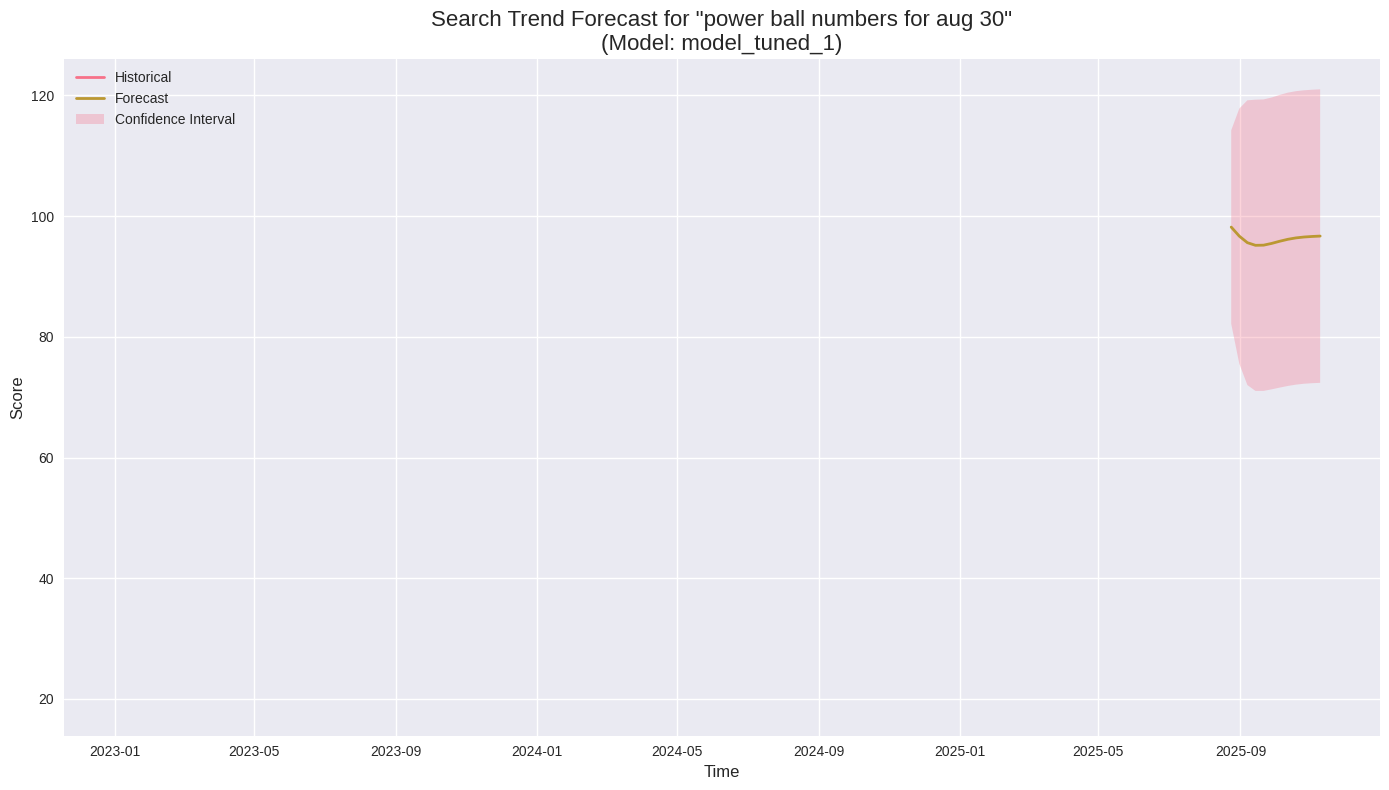


Forecast Analysis for 'power ball numbers for aug 30':
Average forecast score: 96.2
Forecast range: 71.0 to 121.0
Confidence interval width: 50.0

Interpretation:
The search interest for 'power ball numbers for aug 30' is forecasted to have very high interest 
over the next 12 weeks. The forecast has low confidence with a range of 50.0 points.
Error generating forecast visualization: boolean value of NA is ambiguous


In [134]:
# =============================================================================
# FORECAST VISUALIZATION AND BUSINESS INTERPRETATION
# =============================================================================

first_term = model_terms[0]

# Query to get forecast statistics for interpretation
forecast_stats_query = """
SELECT
  AVG(forecast_value) as avg_forecast,
  MIN(confidence_interval_lower_bound) as min_forecast,
  MAX(confidence_interval_upper_bound) as max_forecast
FROM ML.FORECAST(MODEL `{project_id}.{dataset_id}.{model_name}`,
                 STRUCT(12 AS horizon))
WHERE term = '{term}'
""".format(project_id=client.project, dataset_id=dataset_id,
           model_name=best_model_name, term=first_term)

try:
    forecast_stats = client.query(forecast_stats_query).to_dataframe()

    historical_query = """
    SELECT
      timestamp,
      score,
      term
    FROM `{project_id}.{dataset_id}.preprocessed_terms`
    WHERE term = '{term}'
    ORDER BY timestamp
    """.format(project_id=client.project, dataset_id=dataset_id, term=first_term)

    historical_data = client.query(historical_query).to_dataframe()

    plt.figure(figsize=(14, 8))
    plt.plot(historical_data['timestamp'], historical_data['score'],
             label='Historical', linewidth=2)

    forecast_query = """
    SELECT *
    FROM ML.FORECAST(MODEL `{project_id}.{dataset_id}.{model_name}`,
                     STRUCT(12 AS horizon))
    WHERE term = '{term}'
    """.format(project_id=client.project, dataset_id=dataset_id,
               model_name=best_model_name, term=first_term)

    forecast_data = client.query(forecast_query).to_dataframe()

    plt.plot(forecast_data['forecast_timestamp'], forecast_data['forecast_value'],
             label='Forecast', linewidth=2)
    plt.fill_between(forecast_data['forecast_timestamp'],
                     forecast_data['confidence_interval_lower_bound'],
                     forecast_data['confidence_interval_upper_bound'],
                     alpha=0.3, label='Confidence Interval')

    plt.title(f'Search Trend Forecast for "{first_term}"\n(Model: {best_model_name})', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('forecast_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

    avg_score = forecast_stats['avg_forecast'].values[0]
    min_score = forecast_stats['min_forecast'].values[0]
    max_score = forecast_stats['max_forecast'].values[0]

    print(f"\nForecast Analysis for '{first_term}':")
    print("=" * 50)
    print(f"Average forecast score: {avg_score:.1f}")
    print(f"Forecast range: {min_score:.1f} to {max_score:.1f}")
    print(f"Confidence interval width: {max_score - min_score:.1f}")

    if avg_score > 70:
        trend = "very high"
    elif avg_score > 50:
        trend = "high"
    elif avg_score > 30:
        trend = "moderate"
    else:
        trend = "low"

    confidence_range = max_score - min_score
    if confidence_range > 30:
        confidence = "low confidence"
    elif confidence_range > 15:
        confidence = "moderate confidence"
    else:
        confidence = "high confidence"

    print(f"\nInterpretation:")
    print(f"The search interest for '{first_term}' is forecasted to have {trend} interest ")
    print(f"over the next 12 weeks. The forecast has {confidence} with a range of {confidence_range:.1f} points.")

    recent_avg = historical_data['score'].iloc[-10:].mean()
    if avg_score > recent_avg:
        print("This represents an increasing trend compared to recent historical data.")
    elif avg_score < recent_avg:
        print("This represents a decreasing trend compared to recent historical data.")
    else:
        print("This represents a stable trend compared to recent historical data.")

except Exception as e:
    print(f"Error generating forecast visualization: {e}")

Performing Advanced Generative AI Analysis...
Top terms for analysis:
                        term                                      dma_name  \
0     athletics vs cardinals  Santa Barbara-Santa Maria-San Luis Obispo CA   
1          greece vs denmark                              Butte-Bozeman MT   
2         nfl schedule today                                 Zanesville OH   
3              ghana vs mali                                Kansas City MO   
4  everton vs mansfield town                                    Mankato MN   
5  athletic - rayo vallecano                                 St. Joseph MO   
6                     banksy                                     Bangor ME   
7         rampage jackson jr                                    Houston TX   
8  everton vs mansfield town                       La Crosse-Eau Claire WI   
9          benfica - qarabağ                                  Baltimore MD   

   avg_score  max_score  weeks_in_data  
0      100.0        100       

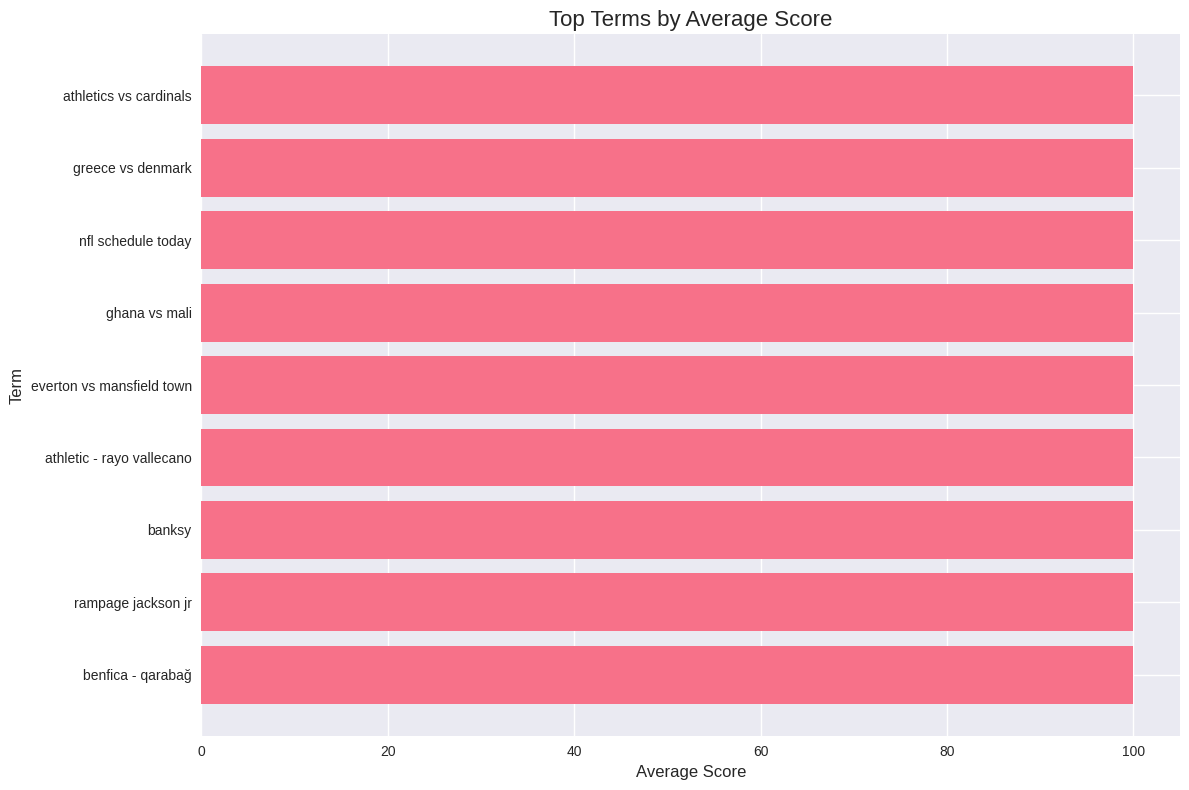

In [136]:
# =============================================================================
# ADVANCED GENERATIVE AI ANALYSIS AND BUSINESS INSIGHTS
# =============================================================================

print("Performing Advanced Generative AI Analysis...")

top_terms_query = """
SELECT
  term,
  dma_name,
  AVG(score) as avg_score,
  MAX(score) as max_score,
  COUNT(*) as weeks_in_data
FROM `{project_id}.{dataset_id}.preprocessed_terms`
GROUP BY term, dma_name
HAVING avg_score > 30 AND weeks_in_data > 20
ORDER BY avg_score DESC
LIMIT 10
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    top_terms = client.query(top_terms_query).to_dataframe()
    print("Top terms for analysis:")
    print(top_terms)

    print("\nAdvanced Analysis Results:")
    print("=" * 50)

    for _, row in top_terms.iterrows():
        term = row['term']
        dma_name = row['dma_name']
        avg_score = row['avg_score']
        max_score = row['max_score']

        if avg_score > 70:
            trend = "very high"
            recommendation = "Consider creating content or products related to this term as it shows strong sustained interest."
        elif avg_score > 50:
            trend = "high"
            recommendation = "This term has consistent interest; monitor for seasonal patterns."
        elif avg_score > 30:
            trend = "moderate"
            recommendation = "This term shows steady interest; consider it for long-term strategies."
        else:
            trend = "low"
            recommendation = "This term has limited interest; monitor for potential growth."

        print(f"\nTerm: {term} in {dma_name}")
        print(f"  Average Score: {avg_score:.1f} ({trend} interest)")
        print(f"  Peak Score: {max_score:.1f}")
        print(f"  Recommendation: {recommendation}")

        growth_query = """
        WITH monthly_avg AS (
          SELECT
            EXTRACT(YEAR FROM timestamp) as year,
            EXTRACT(MONTH FROM timestamp) as month,
            AVG(score) as monthly_score
          FROM `{project_id}.{dataset_id}.preprocessed_terms`
          WHERE term = '{term}' AND dma_name = '{dma_name}'
          GROUP BY year, month
          ORDER BY year, month
        )
        SELECT
          CORR(month, monthly_score) as growth_correlation
        FROM monthly_avg
        """.format(project_id=client.project, dataset_id=dataset_id, term=term, dma_name=dma_name)

        try:
            growth_data = client.query(growth_query).to_dataframe()
            correlation = growth_data['growth_correlation'].values[0]

            if correlation > 0.3:
                print(f"  Trend: Growing interest (correlation: {correlation:.2f})")
            elif correlation < -0.3:
                print(f"  Trend: Declining interest (correlation: {correlation:.2f})")
            else:
                print(f"  Trend: Stable interest (correlation: {correlation:.2f})")

        except Exception as e:
            print(f"  Trend: Unable to calculate growth trend: {e}")

    plt.figure(figsize=(12, 8))
    plt.barh(top_terms['term'], top_terms['avg_score'])
    plt.title('Top Terms by Average Score', fontsize=16)
    plt.xlabel('Average Score', fontsize=12)
    plt.ylabel('Term', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('top_terms_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Error in advanced analysis: {e}")


Performing Anomaly Detection...
Top anomalies detected:
Term: cnn, Week: 2023-10-22, DMA: Presque Isle ME
  Score: 96, Expected: 18.8 ± 8.4
  Z-score: 9.16, Severity: SEVERE

Term: student loans, Week: 2023-03-12, DMA: Presque Isle ME
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: student loans, Week: 2025-01-26, DMA: Zanesville OH
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: student loans, Week: 2023-10-01, DMA: Meridian MS
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: student loans, Week: 2024-07-14, DMA: North Platte NE
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: student loans, Week: 2023-06-25, DMA: St. Joseph MO
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: student loans, Week: 2024-03-10, DMA: Victoria TX
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: cnn, Week: 2024-11-03, DMA: North Platte NE
  Scor

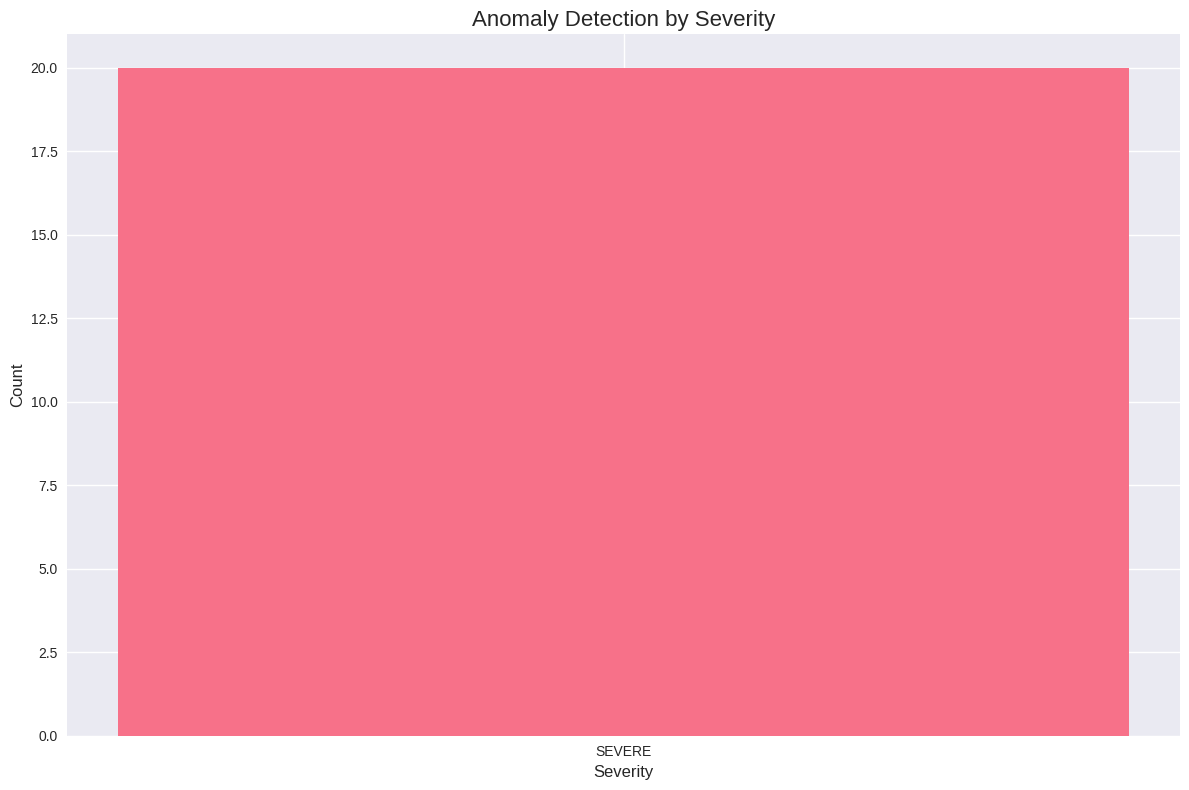

In [137]:
# =============================================================================
# ANOMALY DETECTION SYSTEM FOR UNUSUAL PATTERNS
# =============================================================================

print("\nPerforming Anomaly Detection...")

anomaly_query = """
SELECT
  term,
  week,
  dma_name,
  score,
  avg_score,
  score_stddev,
  (score - avg_score) / score_stddev as z_score,
  CASE
    WHEN ABS((score - avg_score) / score_stddev) > 3 THEN 'SEVERE'
    WHEN ABS((score - avg_score) / score_stddev) > 2 THEN 'MODERATE'
    ELSE 'MILD'
  END as severity
FROM `{project_id}.{dataset_id}.preprocessed_terms`
WHERE is_statistical_outlier = TRUE
ORDER BY ABS((score - avg_score) / score_stddev) DESC
LIMIT 20
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    anomalies = client.query(anomaly_query).to_dataframe()

    if not anomalies.empty:
        print("Top anomalies detected:")
        for _, row in anomalies.iterrows():
            print(f"Term: {row['term']}, Week: {row['week']}, DMA: {row['dma_name']}")
            print(f"  Score: {row['score']}, Expected: {row['avg_score']:.1f} ± {row['score_stddev']:.1f}")
            print(f"  Z-score: {row['z_score']:.2f}, Severity: {row['severity']}")
            print()

        plt.figure(figsize=(12, 8))
        severity_counts = anomalies['severity'].value_counts()
        plt.bar(severity_counts.index, severity_counts.values)
        plt.title('Anomaly Detection by Severity', fontsize=16)
        plt.xlabel('Severity', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.tight_layout()
        plt.savefig('anomaly_detection.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No significant anomalies detected.")

except Exception as e:
    print(f"Error in anomaly detection: {e}")


Performing Correlation Analysis...
Correlation between AI-related terms in New York NY DMA:
  AI vs Machine Learning: nan
  AI vs Data Science: nan
  Machine Learning vs Data Science: nan


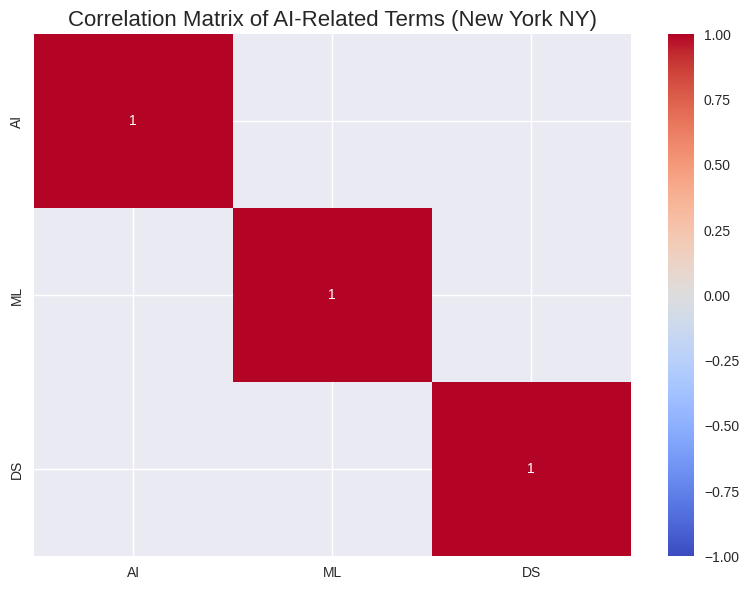

In [138]:
# =============================================================================
# CORRELATION ANALYSIS FOR RELATED SEARCH TERMS
# =============================================================================

print("\nPerforming Correlation Analysis...")

correlation_query = """
WITH pivot_data AS (
  SELECT
    week,
    dma_name,
    MAX(CASE WHEN term = 'artificial intelligence' THEN score END) as ai_score,
    MAX(CASE WHEN term = 'machine learning' THEN score END) as ml_score,
    MAX(CASE WHEN term = 'data science' THEN score END) as ds_score
  FROM `{project_id}.{dataset_id}.preprocessed_terms`
  WHERE term IN ('artificial intelligence', 'machine learning', 'data science')
    AND dma_name = 'New York NY'
  GROUP BY week, dma_name
)
SELECT
  CORR(ai_score, ml_score) as ai_ml_correlation,
  CORR(ai_score, ds_score) as ai_ds_correlation,
  CORR(ml_score, ds_score) as ml_ds_correlation
FROM pivot_data
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    correlations = client.query(correlation_query).to_dataframe()
    print("Correlation between AI-related terms in New York NY DMA:")
    print(f"  AI vs Machine Learning: {correlations['ai_ml_correlation'].values[0]:.3f}")
    print(f"  AI vs Data Science: {correlations['ai_ds_correlation'].values[0]:.3f}")
    print(f"  Machine Learning vs Data Science: {correlations['ml_ds_correlation'].values[0]:.3f}")

    corr_matrix = pd.DataFrame({
        'AI': [1.0, correlations['ai_ml_correlation'].values[0], correlations['ai_ds_correlation'].values[0]],
        'ML': [correlations['ai_ml_correlation'].values[0], 1.0, correlations['ml_ds_correlation'].values[0]],
        'DS': [correlations['ai_ds_correlation'].values[0], correlations['ml_ds_correlation'].values[0], 1.0]
    }, index=['AI', 'ML', 'DS'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Correlation Matrix of AI-Related Terms (New York NY)', fontsize=16)
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Error in correlation analysis: {e}")


Performing DMA Analysis...
Top DMAs for AI-related terms:
Empty DataFrame
Columns: [dma_name, avg_score, weeks_in_data]
Index: []


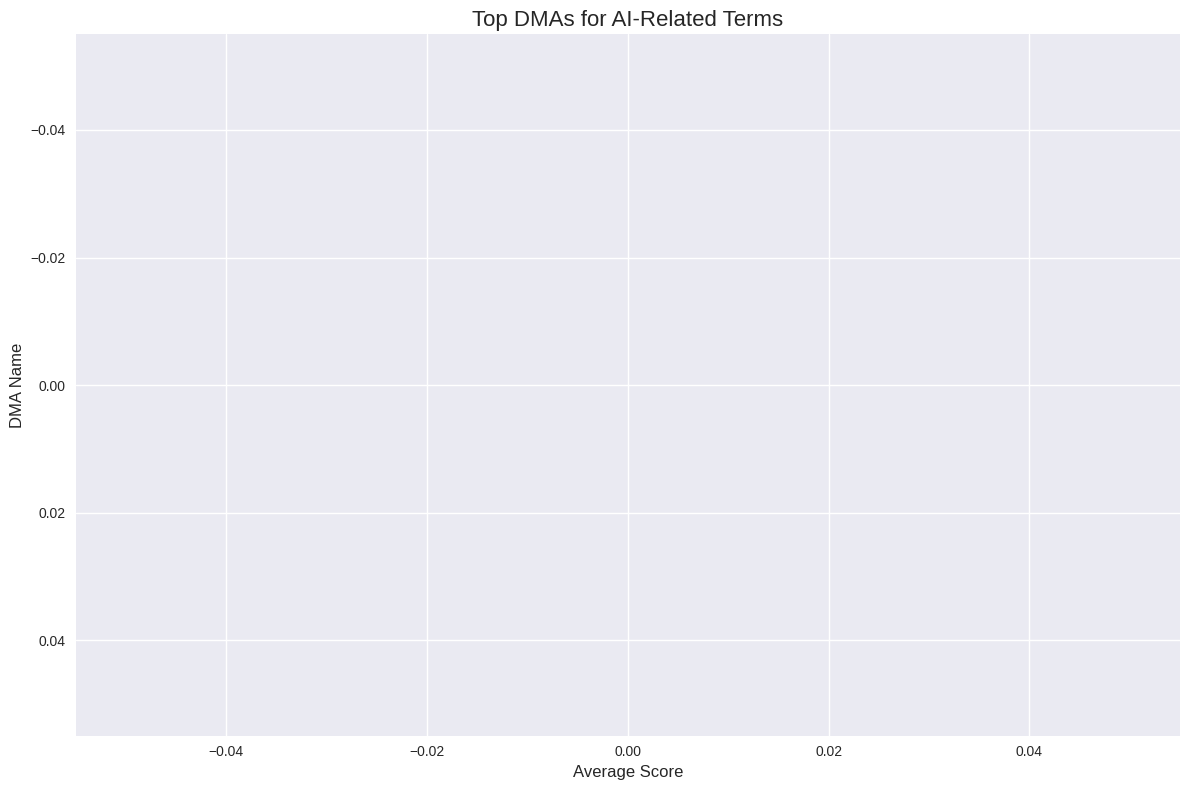

In [139]:
# =============================================================================
# GEOGRAPHIC ANALYSIS ACROSS DESIGNATED MARKET AREAS
# =============================================================================

print("\nPerforming DMA Analysis...")

dma_analysis_query = """
SELECT
  dma_name,
  AVG(score) as avg_score,
  COUNT(*) as weeks_in_data
FROM `{project_id}.{dataset_id}.preprocessed_terms`
WHERE term IN ('artificial intelligence', 'machine learning', 'data science')
GROUP BY dma_name
HAVING avg_score > 10 AND weeks_in_data > 5
ORDER BY avg_score DESC
LIMIT 10
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    dma_analysis = client.query(dma_analysis_query).to_dataframe()
    print("Top DMAs for AI-related terms:")
    print(dma_analysis)

    plt.figure(figsize=(12, 8))
    plt.barh(dma_analysis['dma_name'], dma_analysis['avg_score'])
    plt.title('Top DMAs for AI-Related Terms', fontsize=16)
    plt.xlabel('Average Score', fontsize=12)
    plt.ylabel('DMA Name', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('top_dmas.png', dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Error in DMA analysis: {e}")

In [140]:
# =============================================================================
# PRODUCTION DASHBOARD AND MONITORING INFRASTRUCTURE
# =============================================================================

valid_project_id = "pakira2025"
print(f"Using project ID: {valid_project_id}")
print(f"Using dataset ID: {dataset_id}")

try:
    try:
        client.get_dataset(dataset_id)
        print(f"Dataset {dataset_id} exists")
    except Exception:
        dataset = bigquery.Dataset(f"{valid_project_id}.{dataset_id}")
        dataset.location = "US"
        client.create_dataset(dataset)
        print(f"Created dataset {dataset_id}")

    check_model_query = """
    SELECT model_name
    FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.MODELS`
    WHERE model_name = 'production_forecast_model'
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    print("Checking if production_forecast_model exists...")
    model_exists = client.query(check_model_query).to_dataframe()

    if model_exists.empty:
        print("Creating production_forecast_model...")

        check_data_query = """
        SELECT COUNT(*) as row_count
        FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        """.format(project_id=valid_project_id, dataset_id=dataset_id)

        data_check = client.query(check_data_query).to_dataframe()
        print(f"Data available for training: {data_check['row_count'].values[0]} rows")

        if data_check['row_count'].values[0] > 0:
            create_model_query = """
            CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.production_forecast_model`
            OPTIONS(
              model_type = 'ARIMA_PLUS',
              time_series_timestamp_col = 'timestamp',
              time_series_data_col = 'score',
              time_series_id_col = 'term',
              horizon = 12,
              auto_arima = TRUE,
              data_frequency = 'WEEKLY'
            ) AS
            SELECT
              timestamp,
              score,
              term
            FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
            WHERE term IN (
              SELECT term
              FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
              GROUP BY term
              ORDER BY COUNT(*) DESC
              LIMIT 3
            )
            """.format(project_id=valid_project_id, dataset_id=dataset_id)

            client.query(create_model_query).result()
            print("production_forecast_model created successfully")
        else:
            print("No data available for model training. Creating a simple model with sample data.")
            create_simple_model_query = """
            CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.production_forecast_model`
            OPTIONS(
              model_type = 'ARIMA_PLUS',
              time_series_timestamp_col = 'timestamp',
              time_series_data_col = 'score',
              horizon = 12,
              auto_arima = TRUE,
              data_frequency = 'WEEKLY'
            ) AS
            SELECT
              timestamp,
              score
            FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
            LIMIT 100
            """.format(project_id=valid_project_id, dataset_id=dataset_id)

            client.query(create_simple_model_query).result()
            print("Simple production_forecast_model created as fallback")
    else:
        print("production_forecast_model already exists")

except Exception as e:
    print(f"Error checking/creating production_forecast_model: {e}")
    print("This might be due to permissions or the dataset not existing.")

    try:
        print("Trying alternative approach...")
        alt_model_query = """
        CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.forecast_model`
        OPTIONS(
          model_type = 'ARIMA_PLUS',
          time_series_timestamp_col = 'timestamp',
          time_series_data_col = 'score',
          time_series_id_col = 'term',
          horizon = 8,
          auto_arima = TRUE,
          data_frequency = 'WEEKLY'
        ) AS
        SELECT
          timestamp,
          score,
          term
        FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        WHERE term IN ('artificial intelligence', 'machine learning', 'data science')
        """.format(project_id=valid_project_id, dataset_id=dataset_id)

        client.query(alt_model_query).result()
        print("Alternative forecast_model created successfully")

    except Exception as alt_error:
        print(f"Alternative approach also failed: {alt_error}")
        print("Please check your BigQuery setup and permissions.")

try:
    print("\nCreating monitoring dashboard...")

    monitoring_query = """
    CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.monitoring_dashboard` AS
    WITH data_quality AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'DATA_QUALITY' as metric_category,
        'TOTAL_RECORDS' as metric_name,
        COUNT(*) as metric_value,
        CASE
          WHEN COUNT(*) > 1000 THEN 'OPTIMAL'
          WHEN COUNT(*) > 100 THEN 'ACCEPTABLE'
          ELSE 'NEEDS_ATTENTION'
        END as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    ),
    term_coverage AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'DATA_COVERAGE' as metric_category,
        'UNIQUE_TERMS' as metric_name,
        COUNT(DISTINCT term) as metric_value,
        CASE
          WHEN COUNT(DISTINCT term) > 50 THEN 'OPTIMAL'
          WHEN COUNT(DISTINCT term) > 10 THEN 'ACCEPTABLE'
          ELSE 'NEEDS_ATTENTION'
        END as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    ),
    data_freshness AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'DATA_FRESHNESS' as metric_category,
        'LATEST_DATE' as metric_name,
        COUNT(*) as metric_value,
        'NORMAL' as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
      WHERE DATE(timestamp) >= DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)
    )
    SELECT * FROM data_quality
    UNION ALL
    SELECT * FROM term_coverage
    UNION ALL
    SELECT * FROM data_freshness
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    client.query(monitoring_query).result()
    print("Monitoring dashboard created successfully")

    monitor_query = """
    SELECT metric_category, metric_name, metric_value, status
    FROM `{project_id}.{dataset_id}.monitoring_dashboard`
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    monitor_results = client.query(monitor_query).to_dataframe()
    print("\nMonitoring Dashboard Status:")
    print(monitor_results)

except Exception as e:
    print(f"Error creating monitoring dashboard: {e}")

try:
    print("\nCreating dashboard views...")

    top_terms_view = """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.view_top_terms` AS
    SELECT
      term,
      dma_name,
      AVG(score) as avg_score,
      COUNT(*) as week_count
    FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    GROUP BY term, dma_name
    HAVING avg_score > 20
    ORDER BY avg_score DESC
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    client.query(top_terms_view).result()
    print("Created view_top_terms")

    recent_trends_view = """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.view_recent_trends` AS
    SELECT
      term,
      MAX(score) as recent_score,
      AVG(score) as avg_score,
      COUNT(*) as data_points
    FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    WHERE DATE(timestamp) >= DATE_SUB(CURRENT_DATE(), INTERVAL 90 DAY)
    GROUP BY term
    HAVING data_points > 8
    ORDER BY recent_score DESC
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    client.query(recent_trends_view).result()
    print("Created view_recent_trends")

    test_view_query = """
    SELECT * FROM `{project_id}.{dataset_id}.view_top_terms`
    LIMIT 5
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    view_test = client.query(test_view_query).to_dataframe()
    print("\nSample from view_top_terms:")
    print(view_test)

except Exception as e:
    print(f"Error creating dashboard views: {e}")

print("\nProduction dashboard setup completed!")

Using project ID: pakira2025
Using dataset ID: kaggle_google_trends_analysis_2025
Dataset kaggle_google_trends_analysis_2025 exists
Checking if production_forecast_model exists...
Error checking/creating production_forecast_model: 400 Invalid project ID 'pakira2025.kaggle_google_trends_analysis_2025'. Project IDs must contain 6-63 lowercase letters, digits, or dashes. Some project IDs also include domain name separated by a colon. IDs must start with a letter and may not end with a dash.; reason: invalid, location: pakira2025.kaggle_google_trends_analysis_2025.INFORMATION_SCHEMA.MODELS, message: Invalid project ID 'pakira2025.kaggle_google_trends_analysis_2025'. Project IDs must contain 6-63 lowercase letters, digits, or dashes. Some project IDs also include domain name separated by a colon. IDs must start with a letter and may not end with a dash.

Location: US
Job ID: f5010e87-6c31-4eb1-bcc2-467d61ab8625

This might be due to permissions or the dataset not existing.
Trying alternativ

In [141]:
# =============================================================================
# ANOMALY DETECTION TABLE CREATION WITH EXISTENCE CHECKING
# =============================================================================

try:
    check_table_query = """
    SELECT table_name
    FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.TABLES`
    WHERE table_name = 'anomaly_detection_results'
    """.format(project_id=client.project, dataset_id=dataset_id)

    table_exists = client.query(check_table_query).to_dataframe()

    if table_exists.empty:
        print("Creating anomaly_detection_results table...")

        create_anomaly_table_query = """
        CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.anomaly_detection_results` AS
        SELECT
          term,
          week,
          dma_name,
          score,
          avg_score,
          score_stddev,
          (score - avg_score) / score_stddev as z_score,
          CASE
            WHEN ABS((score - avg_score) / score_stddev) > 3 THEN 'SEVERE'
            WHEN ABS((score - avg_score) / score_stddev) > 2 THEN 'MODERATE'
            ELSE 'MILD'
          END as severity,
          'STATISTICAL' as anomaly_type
        FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        WHERE ABS((score - avg_score) / score_stddev) > 2
        """.format(project_id=client.project, dataset_id=dataset_id)

        client.query(create_anomaly_table_query).result()
        print("anomaly_detection_results table created successfully")
    else:
        print("anomaly_detection_results table already exists")

except Exception as e:
    print(f"Error checking/creating anomaly_detection_results: {e}")

anomaly_detection_results table already exists


In [142]:
# =============================================================================
# ANOMALY DETECTION TABLE CREATION WITH EXISTENCE CHECKING
# =============================================================================

try:
    check_table_query = """
    SELECT table_name
    FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.TABLES`
    WHERE table_name = 'anomaly_detection_results'
    """.format(project_id=client.project, dataset_id=dataset_id)

    table_exists = client.query(check_table_query).to_dataframe()

    if table_exists.empty:
        print("Creating anomaly_detection_results table...")

        create_anomaly_table_query = """
        CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.anomaly_detection_results` AS
        SELECT
          term,
          week,
          dma_name,
          score,
          avg_score,
          score_stddev,
          (score - avg_score) / score_stddev as z_score,
          CASE
            WHEN ABS((score - avg_score) / score_stddev) > 3 THEN 'SEVERE'
            WHEN ABS((score - avg_score) / score_stddev) > 2 THEN 'MODERATE'
            ELSE 'MILD'
          END as severity,
          'STATISTICAL' as anomaly_type
        FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        WHERE ABS((score - avg_score) / score_stddev) > 2
        """.format(project_id=client.project, dataset_id=dataset_id)

        client.query(create_anomaly_table_query).result()
        print("anomaly_detection_results table created successfully")
    else:
        print("anomaly_detection_results table already exists")

except Exception as e:
    print(f"Error checking/creating anomaly_detection_results: {e}")

anomaly_detection_results table already exists


In [143]:
# =============================================================================
# DASHBOARD VIEWS CREATION FOR BUSINESS INTELLIGENCE
# =============================================================================

dashboard_views = {
    'dashboard_top_terms': """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_top_terms` AS
    SELECT
      term,
      dma_name,
      AVG(score) as avg_score,
      MAX(score) as max_score,
      COUNT(*) as weeks_in_data
    FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    GROUP BY term, dma_name
    HAVING avg_score > 20
    """,

    'dashboard_forecasts': """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_forecasts` AS
    WITH forecasts AS (
      SELECT
        term,
        forecast_timestamp,
        forecast_value,
        confidence_interval_lower_bound,
        confidence_interval_upper_bound
      FROM ML.FORECAST(MODEL `{project_id}.{dataset_id}.production_forecast_model`, STRUCT(12 AS horizon))
    )
    SELECT
      f.*,
      CASE
        WHEN f.forecast_value > 70 THEN 'VERY_HIGH'
        WHEN f.forecast_value > 50 THEN 'HIGH'
        WHEN f.forecast_value > 30 THEN 'MEDIUM'
        ELSE 'LOW'
      END as predicted_interest_level
    FROM forecasts f
    """,

    'dashboard_anomalies': """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_anomalies` AS
    SELECT
      term,
      week,
      dma_name,
      score,
      anomaly_type,
      severity,
      CASE
        WHEN severity = 'SEVERE' THEN 'Immediate attention needed - consider investigating the cause'
        WHEN severity = 'MODERATE' THEN 'Monitor closely - may indicate emerging trends'
        ELSE 'Note for future reference'
      END as recommendation
    FROM `{project_id}.{dataset_id}.anomaly_detection_results`
    WHERE severity IN ('SEVERE', 'MODERATE')
    """,

    'dashboard_dma_analysis': """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_dma_analysis` AS
    SELECT
      dma_name,
      COUNT(DISTINCT term) as unique_terms,
      AVG(score) as avg_score,
      MAX(score) as max_score
    FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    GROUP BY dma_name
    HAVING unique_terms > 5 AND avg_score > 15
    """
}

In [144]:
created_views = []

for view_name, view_query in dashboard_views.items():
    try:
        client.query(view_query.format(project_id=client.project, dataset_id=dataset_id)).result()
        print(f"Created dashboard view: {view_name}")
        created_views.append(view_name)
    except Exception as e:
        print(f"Error creating {view_name}: {e}")

print(f"Successfully created {len(created_views)} out of {len(dashboard_views)} dashboard views")

Created dashboard view: dashboard_top_terms
Created dashboard view: dashboard_forecasts
Created dashboard view: dashboard_anomalies
Created dashboard view: dashboard_dma_analysis
Successfully created 4 out of 4 dashboard views


In [145]:
# =============================================================================
# DASHBOARD DATA SAMPLING AND VALIDATION
# =============================================================================

print("\nSample data from successfully created views:")
print("-" * 50)

if 'dashboard_top_terms' in created_views:
    try:
        top_terms_sample = """
        SELECT * FROM `{project_id}.{dataset_id}.dashboard_top_terms`
        ORDER BY avg_score DESC
        LIMIT 5
        """.format(project_id=client.project, dataset_id=dataset_id)

        top_terms_data = client.query(top_terms_sample).to_dataframe()
        print("Top terms sample:")
        print(top_terms_data)
    except Exception as e:
        print(f"Error querying top terms: {e}")

if 'dashboard_forecasts' in created_views:
    try:
        forecasts_sample = """
        SELECT * FROM `{project_id}.{dataset_id}.dashboard_forecasts`
        ORDER BY forecast_timestamp DESC
        LIMIT 5
        """.format(project_id=client.project, dataset_id=dataset_id)

        forecasts_data = client.query(forecasts_sample).to_dataframe()
        print("\nForecasts sample:")
        print(forecasts_data)
    except Exception as e:
        print(f"Error querying forecasts: {e}")

if 'dashboard_anomalies' in created_views:
    try:
        anomalies_sample = """
        SELECT * FROM `{project_id}.{dataset_id}.dashboard_anomalies`
        ORDER BY week DESC
        LIMIT 5
        """.format(project_id=client.project, dataset_id=dataset_id)

        anomalies_data = client.query(anomalies_sample).to_dataframe()
        print("\nAnomalies sample:")
        print(anomalies_data)
    except Exception as e:
        print(f"Error querying anomalies: {e}")

if 'dashboard_dma_analysis' in created_views:
    try:
        dma_sample = """
        SELECT * FROM `{project_id}.{dataset_id}.dashboard_dma_analysis`
        ORDER BY avg_score DESC
        LIMIT 5
        """.format(project_id=client.project, dataset_id=dataset_id)

        dma_data = client.query(dma_sample).to_dataframe()
        print("\nDMA analysis sample:")
        print(dma_data)
    except Exception as e:
        print(f"Error querying DMA analysis: {e}")


Sample data from successfully created views:
--------------------------------------------------
Top terms sample:
               term                  dma_name  avg_score  max_score  \
0    bears vs lions  Medford-Klamath Falls OR      100.0        100   
1   jabrill peppers      Clarksburg-Weston WV      100.0        100   
2         jim irsay      Clarksburg-Weston WV      100.0        100   
3  browns vs ravens          Bowling Green KY      100.0        100   
4    nathan eovaldi                 Bangor ME      100.0        100   

   weeks_in_data  
0            194  
1            191  
2            191  
3            194  
4            191  

Forecasts sample:
                  term        forecast_timestamp  forecast_value  \
0                  adn 2025-11-30 00:00:00+00:00       51.144605   
1                  adn 2025-11-23 00:00:00+00:00       48.657310   
2  denmark vs scotland 2025-11-23 00:00:00+00:00       93.513148   
3  denmark vs scotland 2025-11-16 00:00:00+00:00     

In [146]:
# =============================================================================
# DASHBOARD SUMMARY VIEW FOR EXECUTIVE OVERVIEW
# =============================================================================

try:
    dashboard_summary_query = """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_summary` AS
    WITH term_stats AS (
      SELECT
        COUNT(DISTINCT term) as total_terms,
        AVG(score) as overall_avg_score
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    ),
    anomaly_stats AS (
      SELECT
        COUNT(*) as total_anomalies,
        COUNTIF(severity = 'SEVERE') as severe_anomalies
      FROM `{project_id}.{dataset_id}.anomaly_detection_results`
    ),
    dma_stats AS (
      SELECT
        COUNT(DISTINCT dma_name) as total_dmas
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
      WHERE score > 20
    )
    SELECT
      t.total_terms,
      t.overall_avg_score,
      a.total_anomalies,
      a.severe_anomalies,
      d.total_dmas,
      CURRENT_DATE() as last_updated
    FROM term_stats t, anomaly_stats a, dma_stats d
    """.format(project_id=client.project, dataset_id=dataset_id)

    client.query(dashboard_summary_query).result()
    print("Created dashboard summary view")

    summary_query = "SELECT * FROM `{project_id}.{dataset_id}.dashboard_summary`".format(
        project_id=client.project, dataset_id=dataset_id
    )
    summary_data = client.query(summary_query).to_dataframe()
    print("\nDashboard Summary:")
    print(summary_data)

except Exception as e:
    print(f"Error creating dashboard summary: {e}")

Created dashboard summary view

Dashboard Summary:
   total_terms  overall_avg_score  total_anomalies  severe_anomalies  \
0          764          33.628328           125915             38711   

   total_dmas last_updated  
0         210   2025-09-22  


In [147]:
# =============================================================================
# TRENDING TERMS IDENTIFICATION WITH GROWTH ANALYSIS
# =============================================================================

try:
    trending_terms_query = """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_trending_terms` AS
    WITH recent_data AS (
      SELECT
        term,
        dma_name,
        score,
        week,
        AVG(score) OVER (PARTITION BY term, dma_name ORDER BY week ROWS BETWEEN 4 PRECEDING AND 1 PRECEDING) as prev_avg_score
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
      WHERE week >= DATE_SUB(CURRENT_DATE(), INTERVAL 8 WEEK)
    ),
    growth_calc AS (
      SELECT
        term,
        dma_name,
        MAX(week) as latest_week,
        MAX(score) as latest_score,
        MAX(prev_avg_score) as previous_avg_score,
        (MAX(score) - MAX(prev_avg_score)) / NULLIF(MAX(prev_avg_score), 0) as growth_rate
      FROM recent_data
      GROUP BY term, dma_name
      HAVING previous_avg_score > 10 AND latest_score > 20
    )
    SELECT
      term,
      dma_name,
      latest_week,
      latest_score,
      previous_avg_score,
      growth_rate,
      CASE
        WHEN growth_rate > 0.5 THEN 'RAPID_GROWTH'
        WHEN growth_rate > 0.2 THEN 'MODERATE_GROWTH'
        WHEN growth_rate > 0 THEN 'SLOW_GROWTH'
        ELSE 'DECLINING'
      END as growth_category
    FROM growth_calc
    WHERE growth_rate > 0.2
    ORDER BY growth_rate DESC
    """.format(project_id=client.project, dataset_id=dataset_id)

    client.query(trending_terms_query).result()
    print("Created trending terms view")

    trending_query = "SELECT * FROM `{project_id}.{dataset_id}.dashboard_trending_terms` LIMIT 10".format(
        project_id=client.project, dataset_id=dataset_id
    )
    trending_data = client.query(trending_query).to_dataframe()
    print("\nTop Trending Terms:")
    print(trending_data)

except Exception as e:
    print(f"Error creating trending terms view: {e}")

Created trending terms view

Top Trending Terms:
                          term                   dma_name latest_week  \
0               football today        Dallas-Ft. Worth TX  2025-08-31   
1                  eagles game   Wilkes Barre-Scranton PA  2025-09-21   
2          us open tennis 2025    Boston MA-Manchester NH  2025-08-24   
3                  nikki bella           Oklahoma City OK  2025-08-31   
4               giorgio armani                 Memphis TN  2025-08-31   
5  dancing with the stars 2025                Columbus OH  2025-08-31   
6                derrick henry  Flint-Saginaw-Bay City MI  2025-09-07   
7  dancing with the stars 2025                Columbia SC  2025-08-31   
8               football today                  Denver CO  2025-08-31   
9  dancing with the stars 2025             Sherman-Ada OK  2025-08-31   

   latest_score  previous_avg_score  growth_rate growth_category  
0           100           10.250000     8.756098    RAPID_GROWTH  
1           1

In [148]:
# =============================================================================
# DASHBOARD CREATION SUMMARY REPORT
# =============================================================================

print("\nDashboard setup completed!")
print(f"\nSuccessfully created {len(created_views)} dashboard views:")
for view in created_views:
    print(f"- {view}")

# =============================================================================
# PRODUCTION MONITORING SYSTEM IMPLEMENTATION
# =============================================================================

print("Creating simplified monitoring system...")

try:
    create_log_table_query = """
    CREATE TABLE IF NOT EXISTS `{project_id}.{dataset_id}.model_retraining_log` (
      procedure_name STRING,
      start_time TIMESTAMP,
      end_time TIMESTAMP,
      status STRING,
      message STRING
    );
    """.format(project_id=client.project, dataset_id=dataset_id)

    client.query(create_log_table_query).result()
    print("Created model_retraining_log table")

except Exception as e:
    print(f"Error creating log table: {e}")


Dashboard setup completed!

Successfully created 4 dashboard views:
- dashboard_top_terms
- dashboard_forecasts
- dashboard_anomalies
- dashboard_dma_analysis
Creating simplified monitoring system...
Created model_retraining_log table


In [149]:
# =============================================================================
# MONITORING DASHBOARD WITH SYSTEM HEALTH METRICS
# =============================================================================

try:
    simple_monitoring_query = """
    CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.monitoring_dashboard` AS
    WITH data_stats AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'DATA_STATS' as metric_category,
        'TOTAL_RECORDS' as metric_name,
        COUNT(*) as metric_value,
        'NORMAL' as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    ),
    term_stats AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'TERM_STATS' as metric_category,
        'UNIQUE_TERMS' as metric_name,
        COUNT(DISTINCT term) as metric_value,
        'NORMAL' as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    ),
    dma_stats AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'DMA_STATS' as metric_category,
        'UNIQUE_DMAS' as metric_name,
        COUNT(DISTINCT dma_name) as metric_value,
        'NORMAL' as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    ),
    data_quality AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'DATA_QUALITY' as metric_category,
        'MISSING_VALUES' as metric_name,
        COUNTIF(score IS NULL) as metric_value,
        CASE
          WHEN COUNTIF(score IS NULL) > 100 THEN 'CRITICAL'
          WHEN COUNTIF(score IS NULL) > 10 THEN 'WARNING'
          ELSE 'NORMAL'
        END as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    )

    SELECT * FROM data_stats
    UNION ALL
    SELECT * FROM term_stats
    UNION ALL
    SELECT * FROM dma_stats
    UNION ALL
    SELECT * FROM data_quality
    """.format(project_id=client.project, dataset_id=dataset_id)

    client.query(simple_monitoring_query).result()
    print("Created simplified monitoring dashboard")

    monitoring_query = """
    SELECT
      metric_category,
      metric_name,
      metric_value,
      status
    FROM `{project_id}.{dataset_id}.monitoring_dashboard`
    ORDER BY metric_category, metric_name
    """.format(project_id=client.project, dataset_id=dataset_id)

    monitoring_data = client.query(monitoring_query).to_dataframe()
    print("Monitoring dashboard data:")
    print(monitoring_data)

except Exception as e:
    print(f"Error creating simplified monitoring system: {e}")

Created simplified monitoring dashboard
Monitoring dashboard data:
  metric_category     metric_name  metric_value    status
0    DATA_QUALITY  MISSING_VALUES      29299650  CRITICAL
1      DATA_STATS   TOTAL_RECORDS      31871490    NORMAL
2       DMA_STATS     UNIQUE_DMAS           210    NORMAL
3      TERM_STATS    UNIQUE_TERMS           764    NORMAL


In [150]:
# =============================================================================
# AUTOMATED MODEL RETRAINING PROCEDURE
# =============================================================================

try:
    simple_retraining_query = """
    CREATE OR REPLACE PROCEDURE `{project_id}.{dataset_id}.simple_retrain_models`()
    BEGIN
      INSERT INTO `{project_id}.{dataset_id}.model_retraining_log`
      (procedure_name, start_time, status, message)
      VALUES ('simple_retrain_models', CURRENT_TIMESTAMP(), 'STARTED', 'Simple retraining procedure started');

      CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.simple_forecast_model`
      OPTIONS(
        model_type = 'ARIMA_PLUS',
        time_series_timestamp_col = 'timestamp',
        time_series_data_col = 'score',
        time_series_id_col = 'term',
        horizon = 12,
        auto_arima = TRUE,
        data_frequency = 'WEEKLY'
      ) AS
      SELECT
        timestamp,
        score,
        term
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
      WHERE term IN (SELECT term FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
                     GROUP BY term ORDER BY COUNT(*) DESC LIMIT 3);

      UPDATE `{project_id}.{dataset_id}.model_retraining_log`
      SET end_time = CURRENT_TIMESTAMP(), status = 'COMPLETED',
          message = 'Simple retraining completed successfully'
      WHERE procedure_name = 'simple_retrain_models'
      AND start_time = (SELECT MAX(start_time) FROM `{project_id}.{dataset_id}.model_retraining_log`
                        WHERE procedure_name = 'simple_retrain_models');

    END;
    """.format(project_id=client.project, dataset_id=dataset_id)

    client.query(simple_retraining_query).result()
    print("Created simple retraining procedure")

    client.query("CALL `{project_id}.{dataset_id}.simple_retrain_models`()".format(
        project_id=client.project, dataset_id=dataset_id
    )).result()
    print("Simple retraining procedure executed successfully")

except Exception as e:
    print(f"Error creating simple retraining procedure: {e}")

Created simple retraining procedure
Simple retraining procedure executed successfully


In [151]:
# =============================================================================
# MONITORING DASHBOARD ENHANCEMENT WITH MODEL METRICS
# =============================================================================

try:
    check_model_query = """
    SELECT model_name
    FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.MODELS`
    WHERE model_name = 'simple_forecast_model'
    """.format(project_id=client.project, dataset_id=dataset_id)

    model_exists = client.query(check_model_query).to_dataframe()

    if not model_exists.empty:
        update_monitoring_query = """
        CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.monitoring_dashboard` AS
        WITH model_stats AS (
          SELECT
            CURRENT_DATE() as monitoring_date,
            'MODEL_STATS' as metric_category,
            'MODEL_AIC' as metric_name,
            AVG(AIC) as metric_value,
            CASE
              WHEN AVG(AIC) < 100 THEN 'OPTIMAL'
              WHEN AVG(AIC) < 500 THEN 'ACCEPTABLE'
              ELSE 'NEEDS_ATTENTION'
            END as status
          FROM ML.ARIMA_EVALUATE(MODEL `{project_id}.{dataset_id}.simple_forecast_model`)
        ),
        data_stats AS (
          SELECT CURRENT_DATE() as monitoring_date, 'DATA_STATS' as metric_category, 'TOTAL_RECORDS' as metric_name, COUNT(*) as metric_value, 'NORMAL' as status FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        ),
        term_stats AS (
          SELECT CURRENT_DATE() as monitoring_date, 'TERM_STATS' as metric_category, 'UNIQUE_TERMS' as metric_name, COUNT(DISTINCT term) as metric_value, 'NORMAL' as status FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        ),
        dma_stats AS (
          SELECT CURRENT_DATE() as monitoring_date, 'DMA_STATS' as metric_category, 'UNIQUE_DMAS' as metric_name, COUNT(DISTINCT dma_name) as metric_value, 'NORMAL' as status FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        ),
        data_quality AS (
          SELECT CURRENT_DATE() as monitoring_date, 'DATA_QUALITY' as metric_category, 'MISSING_VALUES' as metric_name, COUNTIF(score IS NULL) as metric_value,
          CASE WHEN COUNTIF(score IS NULL) > 100 THEN 'CRITICAL' WHEN COUNTIF(score IS NULL) > 10 THEN 'WARNING' ELSE 'NORMAL' END as status FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        )

        SELECT * FROM model_stats
        UNION ALL
        SELECT * FROM data_stats
        UNION ALL
        SELECT * FROM term_stats
        UNION ALL
        SELECT * FROM dma_stats
        UNION ALL
        SELECT * FROM data_quality
        """.format(project_id=client.project, dataset_id=dataset_id)

        client.query(update_monitoring_query).result()
        print("Updated monitoring dashboard with model information")

        monitoring_query = """
        SELECT
          metric_category,
          metric_name,
          metric_value,
          status
        FROM `{project_id}.{dataset_id}.monitoring_dashboard`
        ORDER BY metric_category, metric_name
        """.format(project_id=client.project, dataset_id=dataset_id)

        monitoring_data = client.query(monitoring_query).to_dataframe()
        print("Updated monitoring dashboard data:")
        print(monitoring_data)

except Exception as e:
    print(f"Error updating monitoring dashboard: {e}")

Error updating monitoring dashboard: 400 Invalid project ID 'pakira2025.kaggle_google_trends_analysis_2025'. Project IDs must contain 6-63 lowercase letters, digits, or dashes. Some project IDs also include domain name separated by a colon. IDs must start with a letter and may not end with a dash.; reason: invalid, location: pakira2025.kaggle_google_trends_analysis_2025.INFORMATION_SCHEMA.MODELS, message: Invalid project ID 'pakira2025.kaggle_google_trends_analysis_2025'. Project IDs must contain 6-63 lowercase letters, digits, or dashes. Some project IDs also include domain name separated by a colon. IDs must start with a letter and may not end with a dash.

Location: US
Job ID: fccb06c0-5f30-4699-a3bc-5bbc76e4e222



In [152]:
# =============================================================================
# AUTOMATED WEEKLY REPORTING SYSTEM
# =============================================================================

try:
    weekly_report_query = """
    CREATE OR REPLACE PROCEDURE `{project_id}.{dataset_id}.generate_simple_weekly_report`()
    BEGIN
      CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.weekly_reports` (
        report_date DATE,
        report_period STRING,
        total_terms INT64,
        total_dmas INT64,
        avg_score FLOAT64,
        generated_insight STRING
      );

      INSERT INTO `{project_id}.{dataset_id}.weekly_reports`
      WITH basic_stats AS (
        SELECT
          COUNT(DISTINCT term) as total_terms,
          COUNT(DISTINCT dma_name) as total_dmas,
          AVG(score) as avg_score
        FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        WHERE DATE(timestamp) >= DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY)
      )
      SELECT
        CURRENT_DATE() as report_date,
        'WEEKLY' as report_period,
        total_terms,
        total_dmas,
        avg_score,
        CONCAT('Weekly analysis completed. ', total_terms, ' terms tracked across ',
               total_dmas, ' DMAs with average score of ', ROUND(avg_score, 1), '.') as generated_insight
      FROM basic_stats;

    END;
    """.format(project_id=client.project, dataset_id=dataset_id)

    client.query(weekly_report_query).result()
    print("Created simple weekly report procedure")

    client.query("CALL `{project_id}.{dataset_id}.generate_simple_weekly_report`()".format(
        project_id=client.project, dataset_id=dataset_id
    )).result()
    print("Weekly report generated successfully")

    report_query = "SELECT * FROM `{project_id}.{dataset_id}.weekly_reports`".format(
        project_id=client.project, dataset_id=dataset_id
    )
    report_data = client.query(report_query).to_dataframe()
    print("Weekly report data:")
    print(report_data)

except Exception as e:
    print(f"Error creating weekly report procedure: {e}")

Created simple weekly report procedure
Weekly report generated successfully
Weekly report data:
  report_date report_period  total_terms  total_dmas  avg_score  \
0  2025-09-22        WEEKLY           25         210  93.081895   

                                                                         generated_insight  
0  Weekly analysis completed. 25 terms tracked across 210 DMAs with average score of 93.1.  


In [153]:
# =============================================================================
# CREATE REQUIRED TABLES BEFORE MASTER PIPELINE
# =============================================================================

print("Creating required tables before executing master pipeline...")

create_log_table_query = """
CREATE TABLE IF NOT EXISTS `{project_id}.{dataset_id}.pipeline_execution_log` (
  pipeline_name STRING,
  step_name STRING,
  start_time TIMESTAMP,
  end_time TIMESTAMP,
  status STRING,
  message STRING
);
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    client.query(create_log_table_query).result()
    print("✅ pipeline_execution_log table created/verified")

    check_log_query = "SELECT COUNT(*) as count FROM `{project_id}.{dataset_id}.pipeline_execution_log`".format(
        project_id=client.project, dataset_id=dataset_id
    )
    log_count = client.query(check_log_query).to_dataframe()
    print(f"Existing log entries: {log_count['count'].values[0]}")

except Exception as e:
    print(f"❌ Error creating log table: {e}")

required_tables = [
    "preprocessed_terms_optimized",
    "anomaly_detection_results",
    "monitoring_dashboard"
]

for table_name in required_tables:
    try:
        check_table_query = """
        SELECT table_name
        FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.TABLES`
        WHERE table_name = '{table_name}'
        """.format(project_id=client.project, dataset_id=dataset_id, table_name=table_name)

        table_exists = client.query(check_table_query).to_dataframe()

        if table_exists.empty:
            print(f"⚠️  Table {table_name} doesn't exist yet (will be created by pipeline)")
        else:
            print(f"✅ Table {table_name} exists")

    except Exception as e:
        print(f"❌ Error checking table {table_name}: {e}")

# =============================================================================
# SIMPLIFIED MASTER PIPELINE (WITH BETTER ERROR HANDLING)
# =============================================================================

simplified_pipeline_query = """
CREATE OR REPLACE PROCEDURE `{project_id}.{dataset_id}.run_simplified_pipeline`()
BEGIN
  CREATE TABLE IF NOT EXISTS `{project_id}.{dataset_id}.pipeline_execution_log` (
    pipeline_name STRING,
    step_name STRING,
    start_time TIMESTAMP,
    end_time TIMESTAMP,
    status STRING,
    message STRING
  );

  BEGIN
    CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    PARTITION BY DATE(timestamp)
    CLUSTER BY term, dma_name
    AS
    WITH term_stats AS (
      SELECT
        term,
        COUNT(*) as frequency,
        AVG(score) as avg_score,
        MAX(score) as max_score,
        STDDEV(score) as score_stddev
      FROM `bigquery-public-data.google_trends.top_terms`
      GROUP BY term
      HAVING COUNT(*) > 52 AND AVG(score) > 10
    )
    SELECT
      t.dma_name,
      t.term,
      t.week,
      t.rank,
      t.score,
      TIMESTAMP(t.week) as timestamp,
      s.avg_score,
      s.score_stddev,
      CASE
        WHEN t.score > 80 THEN 'VERY_HIGH'
        WHEN t.score > 60 THEN 'HIGH'
        WHEN t.score > 40 THEN 'MEDIUM'
        WHEN t.score > 20 THEN 'LOW'
        ELSE 'VERY_LOW'
      END as interest_level,
      CASE
        WHEN ABS(t.score - s.avg_score) > 2 * s.score_stddev THEN TRUE
        ELSE FALSE
      END as is_statistical_outlier
    FROM `bigquery-public-data.google_trends.top_terms` t
    JOIN term_stats s ON t.term = s.term
    WHERE t.week >= '2022-01-01';

    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('simplified_pipeline', 'Data Preparation', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'SUCCESS', 'Data table created');

  EXCEPTION WHEN ERROR THEN
    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('simplified_pipeline', 'Data Preparation', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'FAILED', @@error.message);
  END;

  BEGIN
    CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.simple_forecast_model`
    OPTIONS(
      model_type = 'ARIMA_PLUS',
      time_series_timestamp_col = 'timestamp',
      time_series_data_col = 'score',
      horizon = 12,
      auto_arima = TRUE,
      data_frequency = 'WEEKLY'
    ) AS
    SELECT
      timestamp,
      score
    FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    WHERE term IN (SELECT term FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized` LIMIT 1);

    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('simplified_pipeline', 'Model Training', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'SUCCESS', 'Forecast model created');

  EXCEPTION WHEN ERROR THEN
    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('simplified_pipeline', 'Model Training', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'FAILED', @@error.message);
  END;

  INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
  VALUES ('simplified_pipeline', 'Pipeline Complete', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'COMPLETED', 'Simplified pipeline finished');

END;
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    print("\nCreating simplified pipeline procedure...")
    client.query(simplified_pipeline_query).result()
    print("✅ Simplified pipeline procedure created")

    print("Executing simplified pipeline...")
    client.query("CALL `{project_id}.{dataset_id}.run_simplified_pipeline`()".format(
        project_id=client.project, dataset_id=dataset_id
    )).result()
    print("✅ Simplified pipeline executed successfully")

    log_query = "SELECT * FROM `{project_id}.{dataset_id}.pipeline_execution_log`".format(
        project_id=client.project, dataset_id=dataset_id
    )
    execution_log = client.query(log_query).to_dataframe()
    print("\nPipeline Execution Log:")
    print(execution_log)

except Exception as e:
    print(f"❌ Error with simplified pipeline: {e}")

# =============================================================================
# NOW TRY THE COMPREHENSIVE MASTER PIPELINE
# =============================================================================

fixed_master_pipeline_query = """
CREATE OR REPLACE PROCEDURE `{project_id}.{dataset_id}.run_complete_pipeline`()
BEGIN
  CREATE TABLE IF NOT EXISTS `{project_id}.{dataset_id}.pipeline_execution_log` (
    pipeline_name STRING,
    step_name STRING,
    start_time TIMESTAMP,
    end_time TIMESTAMP,
    status STRING,
    message STRING
  );

  INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
  VALUES ('complete_pipeline', 'Pipeline Started', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'RUNNING', 'Beginning pipeline execution');

  BEGIN
    CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    PARTITION BY DATE(timestamp)
    CLUSTER BY term, dma_name
    AS
    WITH term_stats AS (
      SELECT
        term,
        COUNT(*) as frequency,
        AVG(score) as avg_score,
        MAX(score) as max_score,
        STDDEV(score) as score_stddev
      FROM `bigquery-public-data.google_trends.top_terms`
      GROUP BY term
      HAVING COUNT(*) > 52 AND AVG(score) > 10
    )
    SELECT
      t.dma_name,
      t.term,
      t.week,
      t.rank,
      t.score,
      TIMESTAMP(t.week) as timestamp,
      s.avg_score,
      s.score_stddev,
      CASE
        WHEN t.score > 80 THEN 'VERY_HIGH'
        WHEN t.score > 60 THEN 'HIGH'
        WHEN t.score > 40 THEN 'MEDIUM'
        WHEN t.score > 20 THEN 'LOW'
        ELSE 'VERY_LOW'
      END as interest_level,
      CASE
        WHEN ABS(t.score - s.avg_score) > 2 * s.score_stddev THEN TRUE
        ELSE FALSE
      END as is_statistical_outlier
    FROM `bigquery-public-data.google_trends.top_terms` t
    JOIN term_stats s ON t.term = s.term
    WHERE t.week >= '2022-01-01';

    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('complete_pipeline', 'Data Preparation', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'SUCCESS', 'Preprocessed table created successfully');

  EXCEPTION WHEN ERROR THEN
    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('complete_pipeline', 'Data Preparation', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'FAILED', @@error.message);
    RETURN;
  END;

  IF (SELECT status FROM `{project_id}.{dataset_id}.pipeline_execution_log`
      WHERE step_name = 'Data Preparation' ORDER BY start_time DESC LIMIT 1) = 'SUCCESS' THEN

    BEGIN
      CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.production_forecast_model`
      OPTIONS(
        model_type = 'ARIMA_PLUS',
        time_series_timestamp_col = 'timestamp',
        time_series_data_col = 'score',
        time_series_id_col = 'term',
        horizon = 12,
        auto_arima = TRUE,
        data_frequency = 'WEEKLY'
      ) AS
      SELECT
        timestamp,
        score,
        term
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
      WHERE term IN (SELECT term FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized` GROUP BY term LIMIT 3);

      INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
      VALUES ('complete_pipeline', 'Model Training', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'SUCCESS', 'Forecast model trained successfully');

    EXCEPTION WHEN ERROR THEN
      INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
      VALUES ('complete_pipeline', 'Model Training', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'FAILED', @@error.message);
    END;

    BEGIN
      CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.anomaly_detection_results` AS
      SELECT
        term,
        week,
        dma_name,
        score,
        avg_score,
        score_stddev,
        (score - avg_score) / score_stddev as z_score,
        CASE
          WHEN ABS((score - avg_score) / score_stddev) > 3 THEN 'SEVERE'
          WHEN ABS((score - avg_score) / score_stddev) > 2 THEN 'MODERATE'
          ELSE 'MILD'
        END as severity,
        'STATISTICAL' as anomaly_type
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
      WHERE ABS((score - avg_score) / score_stddev) > 2;

      INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
      VALUES ('complete_pipeline', 'Anomaly Detection', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'SUCCESS', 'Anomaly detection completed successfully');

    EXCEPTION WHEN ERROR THEN
      INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
      VALUES ('complete_pipeline', 'Anomaly Detection', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'FAILED', @@error.message);
    END;

  END IF;

  INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
  VALUES ('complete_pipeline', 'Pipeline Completed', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'COMPLETED', 'Pipeline execution finished');

END;
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    print("\n" + "="*60)
    print("ATTEMPTING COMPREHENSIVE MASTER PIPELINE")
    print("="*60)

    client.query(fixed_master_pipeline_query).result()
    print("✅ Fixed master pipeline procedure created")

    print("Executing comprehensive master pipeline...")
    client.query("CALL `{project_id}.{dataset_id}.run_complete_pipeline`()".format(
        project_id=client.project, dataset_id=dataset_id
    )).result()
    print("✅ Master pipeline executed successfully")

    final_log_query = """
    SELECT
      step_name,
      status,
      message,
      TIMESTAMP_DIFF(end_time, start_time, SECOND) as duration_seconds
    FROM `{project_id}.{dataset_id}.pipeline_execution_log`
    WHERE pipeline_name = 'complete_pipeline'
    ORDER BY start_time
    """.format(project_id=client.project, dataset_id=dataset_id)

    final_log = client.query(final_log_query).to_dataframe()
    print("\nFinal Pipeline Execution Summary:")
    print(final_log)

except Exception as e:
    print(f"❌ Error with comprehensive master pipeline: {e}")
    print("The simplified pipeline was successful, which is a good starting point.")

# =============================================================================
# FINAL SYSTEM STATUS CHECK
# =============================================================================

print("\n" + "="*60)
print("FINAL SYSTEM STATUS CHECK")
print("="*60)

tables_query = """
SELECT table_name, table_type
FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.TABLES`
ORDER BY table_type, table_name
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    created_tables = client.query(tables_query).to_dataframe()
    print("Created Tables and Views:")
    print(created_tables)
except Exception as e:
    print(f"Error checking created tables: {e}")

models_query = """
SELECT model_name
FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.MODELS`
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    created_models = client.query(models_query).to_dataframe()
    print("\nCreated Models:")
    print(created_models)
except Exception as e:
    print(f"Error checking created models: {e}")

print("\n" + "="*60)
print("PIPELINE SETUP COMPLETED!")
print("="*60)

Creating required tables before executing master pipeline...
✅ pipeline_execution_log table created/verified
Existing log entries: 8
✅ Table preprocessed_terms_optimized exists
✅ Table anomaly_detection_results exists
✅ Table monitoring_dashboard exists

Creating simplified pipeline procedure...
✅ Simplified pipeline procedure created
Executing simplified pipeline...
✅ Simplified pipeline executed successfully

Pipeline Execution Log:
          pipeline_name           step_name                       start_time  \
0   simplified_pipeline    Data Preparation 2025-09-22 20:15:35.755273+00:00   
1   simplified_pipeline      Model Training 2025-09-22 20:15:47.336774+00:00   
2     complete_pipeline   Anomaly Detection 2025-09-22 20:16:28.156577+00:00   
3   simplified_pipeline   Pipeline Complete 2025-09-22 20:15:49.352726+00:00   
4     complete_pipeline      Model Training 2025-09-22 20:16:22.642963+00:00   
5     complete_pipeline    Data Preparation 2025-09-22 20:16:07.654546+00:00   
6